## Final Project
#### Course Name: Independent Study - Survival Analysis
#### Name: Shrinidhi Rajesh

In [1]:
# Libraries Utilized
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test
from tabulate import tabulate
import warnings
from lifelines import CoxPHFitter
import matplotlib as mpl
import numpy as np
from lifelines import CoxPHFitter
# !pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

In [2]:
# Loading the CSV file
canine = pd.read_csv('Canine_Survival_Analysis.csv')

# Displaying the first few rows
print(canine.head())

   PatientID   site  Died    how died  Pre-ACTH  Post-ACTH Insurance  weight  \
0        1.0  183.0   0.0           0       0.0        0.0         0    7.55   
1        2.0  284.0   0.0           0       0.0        0.0         0    7.20   
2        3.0  182.0   1.0           0     267.0      922.0         0   12.50   
3        4.0  284.0   1.0           0       0.0        0.0         0   19.00   
4        5.0  159.0   1.0  Euthanasia     145.0      684.0   Insured   34.25   

   BreedRelativeWeight   BirthDate  ... Complications Hypertensive_Yes4  \
0                  1.0  14-05-2003  ...       Unknown           Unknown   
1                  1.0  07-11-2002  ...       Unknown           Unknown   
2                  2.0  01-02-2005  ...       Unknown           Unknown   
3                  1.0  09-10-2003  ...       Unknown           Unknown   
4                  2.0  01-07-2004  ...           Yes               Yes   

  Oversuppresion? Cortisol stayed <250  Cortisol went <40  \
0      

### Analyzing and Preprocessing - Part 1

In [3]:
# Printing the column names
print(canine.columns)
print(f"Total number of columns: {len(canine.columns)}")

Index(['PatientID', 'site', 'Died', 'how died', 'Pre-ACTH', 'Post-ACTH',
       'Insurance', 'weight', 'BreedRelativeWeight', 'BirthDate', 'Sex',
       'Isneutered', 'Breed', 'KC_group', 'Purebreed_status',
       'Date of diagnosis_3', 'Failuredate', 'Date of first suspicion_4',
       'Date trilostane started_5', 'Changes to trilostane_6', 'Stay_vs_stop',
       'Treated with trilostane_7', 'Trilostane starting dose (mg/kg)_8',
       'Trilostane SID/BID_9', 'Censored_10', 'Why censored_11',
       'Cause of death_13', 'Neuro signs', 'Complications',
       'Hypertensive_Yes4', 'Oversuppresion?', 'Cortisol stayed <250',
       'Cortisol went <40', 'Number_comorbidities', 'comorb_UTI', 'comorb_dm',
       'comorb_hypot', 'Unnamed: 37'],
      dtype='object')
Total number of columns: 38


In [4]:
# Removing the last column
canine = canine.iloc[:, :-1]

# Verifying the number of columns after removal
print(f"Total number of columns after removal: {len(canine.columns)}")

Total number of columns after removal: 37


In [5]:
# Displaying detailed information about the DataFrame
print(canine.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PatientID                           219 non-null    float64
 1   site                                219 non-null    float64
 2   Died                                219 non-null    float64
 3   how died                            219 non-null    object 
 4   Pre-ACTH                            219 non-null    float64
 5   Post-ACTH                           219 non-null    float64
 6   Insurance                           219 non-null    object 
 7   weight                              219 non-null    float64
 8   BreedRelativeWeight                 219 non-null    float64
 9   BirthDate                           219 non-null    object 
 10  Sex                                 219 non-null    object 
 11  Isneutered                          219 non-n

In [6]:
# Creating a subset excluding PatientID
canine_subset = canine.iloc[:219].drop('PatientID', axis=1)

# Total columns in subset
print(f"Total number of columns in the subset: {len(canine_subset.columns)}")

# Total rows in subset
print(f"Number of rows in canine_subset: {len(canine_subset)}")
print(canine_subset.head())
print(canine_subset.tail())

# Converting the 'Died' column from float to int
canine_subset['Died'] = canine_subset['Died'].astype(int)

# Printing the unique and the first few values to confirm the conversion
print("Unique values in 'Died' column:", canine_subset['Died'].unique())
print(canine_subset['Died'].head())

Total number of columns in the subset: 36
Number of rows in canine_subset: 219
    site  Died    how died  Pre-ACTH  Post-ACTH Insurance  weight  \
0  183.0   0.0           0       0.0        0.0         0    7.55   
1  284.0   0.0           0       0.0        0.0         0    7.20   
2  182.0   1.0           0     267.0      922.0         0   12.50   
3  284.0   1.0           0       0.0        0.0         0   19.00   
4  159.0   1.0  Euthanasia     145.0      684.0   Insured   34.25   

   BreedRelativeWeight   BirthDate     Sex  ... Neuro signs Complications  \
0                  1.0  14-05-2003    male  ...          No       Unknown   
1                  1.0  07-11-2002  Female  ...          No       Unknown   
2                  2.0  01-02-2005    male  ...          No       Unknown   
3                  1.0  09-10-2003  Female  ...          No       Unknown   
4                  2.0  01-07-2004    male  ...          No           Yes   

  Hypertensive_Yes4  Oversuppresion? Cortis

In [7]:
# Calculating the frequency table for 'site' column
site_freq = canine_subset['site'].value_counts()
site_percent = canine_subset['site'].value_counts(normalize=True, dropna=False) * 100

print("Frequency table for 'site':")
print("Value  Frequency  Percentage")
for value, count in site_freq.items():
    percentage = site_percent[value]
    print(f"{value:<6} {count:<10} {percentage:.2f}%")

print(f"\nTotal number of entries: {len(canine_subset)}")
print(f"Number of unique values: {canine_subset['site'].nunique()}")
print(f"Number of missing values: {canine_subset['site'].isnull().sum()}")

Frequency table for 'site':
Value  Frequency  Percentage
174.0  7          3.20%
120.0  7          3.20%
118.0  7          3.20%
132.0  6          2.74%
160.0  6          2.74%
196.0  6          2.74%
198.0  6          2.74%
135.0  6          2.74%
126.0  5          2.28%
178.0  5          2.28%
123.0  5          2.28%
115.0  5          2.28%
140.0  5          2.28%
173.0  4          1.83%
199.0  4          1.83%
133.0  4          1.83%
131.0  4          1.83%
136.0  4          1.83%
163.0  4          1.83%
197.0  4          1.83%
189.0  4          1.83%
151.0  4          1.83%
164.0  4          1.83%
157.0  3          1.37%
107.0  3          1.37%
122.0  3          1.37%
111.0  3          1.37%
145.0  3          1.37%
138.0  3          1.37%
108.0  3          1.37%
121.0  3          1.37%
139.0  3          1.37%
169.0  3          1.37%
144.0  3          1.37%
106.0  3          1.37%
166.0  3          1.37%
159.0  3          1.37%
110.0  3          1.37%
183.0  2          0.91%
168.0  

In [8]:
# "site" column not so informative, thus dropping from the analysis
canine_subset = canine_subset.iloc[:, 1:]
# Total columns in subset
print(f"Total number of columns in the subset: {len(canine_subset.columns)}")
# Colmun names in subset
print(f"Column names in the subset: {canine_subset.columns}")

Total number of columns in the subset: 35
Column names in the subset: Index(['Died', 'how died', 'Pre-ACTH', 'Post-ACTH', 'Insurance', 'weight',
       'BreedRelativeWeight', 'BirthDate', 'Sex', 'Isneutered', 'Breed',
       'KC_group', 'Purebreed_status', 'Date of diagnosis_3', 'Failuredate',
       'Date of first suspicion_4', 'Date trilostane started_5',
       'Changes to trilostane_6', 'Stay_vs_stop', 'Treated with trilostane_7',
       'Trilostane starting dose (mg/kg)_8', 'Trilostane SID/BID_9',
       'Censored_10', 'Why censored_11', 'Cause of death_13', 'Neuro signs',
       'Complications', 'Hypertensive_Yes4', 'Oversuppresion?',
       'Cortisol stayed <250', 'Cortisol went <40', 'Number_comorbidities',
       'comorb_UTI', 'comorb_dm', 'comorb_hypot'],
      dtype='object')


In [9]:
# Printing the count of NaN values in each column
print("Count of NaN values in each column before replacement:")
print(canine_subset.isnull().sum())
# There were a total of 393 rows initially.
# Removing the nulls resulted in a dataset of 219 rows

Count of NaN values in each column before replacement:
Died                                    0
how died                                0
Pre-ACTH                                0
Post-ACTH                               0
Insurance                               0
weight                                  0
BreedRelativeWeight                     0
BirthDate                               0
Sex                                     0
Isneutered                              0
Breed                                   0
KC_group                                0
Purebreed_status                        0
Date of diagnosis_3                     0
Failuredate                             0
Date of first suspicion_4               0
Date trilostane started_5              14
Changes to trilostane_6                13
Stay_vs_stop                            0
Treated with trilostane_7               0
Trilostane starting dose (mg/kg)_8     20
Trilostane SID/BID_9                   13
Censored_10          

In [10]:
# Creating the categorical_columns
categorical_columns = [
    'Died',
    'how died',
    'Insurance',
    'Sex',
    'Isneutered',
    'Breed',
    'KC_group',
    'BreedRelativeWeight',
    'Purebreed_status',
    'Changes to trilostane_6',
    'Stay_vs_stop',
    'Treated with trilostane_7',
    'Trilostane SID/BID_9',
    'Censored_10',
    'Why censored_11',
    'Cause of death_13',
    'Neuro signs',
    'Complications',
    'Hypertensive_Yes4',
    'Oversuppresion?',
    'Cortisol stayed <250',
    'Cortisol went <40',
    'Number_comorbidities',
    'comorb_UTI',
    'comorb_dm',
    'comorb_hypot'
]

# Converting the specified columns to categorical (factor)
for col in categorical_columns:
    canine_subset[col] = canine_subset[col].astype('category')

# Generating the descriptive statistics for each categorical variable
descriptive_stats = {}
for col in categorical_columns:
    descriptive_stats[col] = canine_subset[col].value_counts(dropna=False)

# Printing the descriptive statistics
for col, stats in descriptive_stats.items():
    print(f"\nDescriptive statistics for '{col}':")
    print(stats)


Descriptive statistics for 'Died':
Died
1    179
0     40
Name: count, dtype: int64

Descriptive statistics for 'how died':
how died
Euthanasia    126
0              73
Unassisted     19
Unknown         1
Name: count, dtype: int64

Descriptive statistics for 'Insurance':
Insurance
Insured      126
Uninsured     52
0             41
Name: count, dtype: int64

Descriptive statistics for 'Sex':
Sex
male      115
Female    104
Name: count, dtype: int64

Descriptive statistics for 'Isneutered':
Isneutered
Yes    169
No      50
Name: count, dtype: int64

Descriptive statistics for 'Breed':
Breed
Crossbreed                                                                                                   47
Terrier - Jack Russell (JRT)                                                                                 21
Terrier - Yorkshire (Yorkshire Terrier)                                                                      16
Bichon - Frise                                                     

Descriptive Statistics for Continuous Variables:
         Pre-ACTH    Post-ACTH      weight  Trilostane starting dose (mg/kg)_8
count  219.000000   219.000000  219.000000                          199.000000
mean    53.794064   301.045662   16.314064                            3.301508
std    101.191170   440.164489   10.872733                            1.275695
min      0.000000     0.000000    0.000000                            1.000000
25%      0.000000     0.000000    9.200000                            2.500000
50%      0.000000     0.000000   12.750000                            3.000000
75%     88.850000   682.500000   20.350000                            4.000000
max    508.000000  1380.000000   65.600000                            8.000000


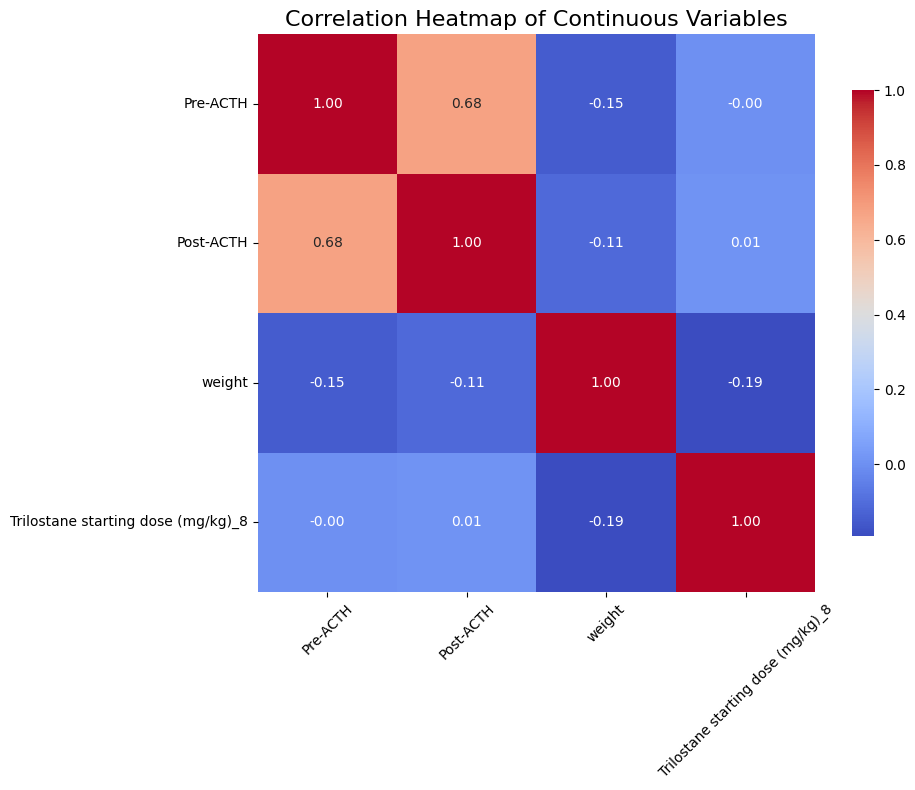

In [11]:
# Creating the continuous_columns
continuous_columns = [
    'Pre-ACTH',
    'Post-ACTH',
    'weight',
    'Trilostane starting dose (mg/kg)_8'
]

# Generating descriptive statistics for continuous variables
descriptive_stats = canine_subset[continuous_columns].describe()

# Printing the descriptive statistics
print("Descriptive Statistics for Continuous Variables:")
print(descriptive_stats)

# Calculating the correlation matrix
correlation_matrix = canine_subset[continuous_columns].corr()

# Setting up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generating the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Setting titles and labels
plt.title('Correlation Heatmap of Continuous Variables', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Showing the plot
plt.show()

In [12]:
# Converting date columns to datetime format 
date_columns = [
    'BirthDate',
    'Date of first suspicion_4',
    'Date of diagnosis_3',
    'Date trilostane started_5',
    'Failuredate'
]

for col in date_columns:
    canine_subset[col] = pd.to_datetime(canine_subset[col], format='%d-%m-%Y', errors='coerce')

# Filtering for uncensored data (Died = 1)
uncensored_data = canine_subset[canine_subset['Died'] == 1].copy()  # Using .copy() to avoid SettingWithCopyWarning

# Counting of the uncensored entries
count_uncensored = len(uncensored_data)

# Earliest and latest dates
earliest_dates = uncensored_data[date_columns].min()
latest_dates = uncensored_data[date_columns].max()

# Date ranges
date_ranges = latest_dates - earliest_dates

# Calculating the time intervals using .loc to avoid warnings
uncensored_data.loc[:, 'Time_Birth_to_Suspicion'] = (uncensored_data['Date of first suspicion_4'] - uncensored_data['BirthDate']).dt.days
uncensored_data.loc[:, 'Time_Suspicion_to_Diagnosis'] = (uncensored_data['Date of diagnosis_3'] - uncensored_data['Date of first suspicion_4']).dt.days
uncensored_data.loc[:, 'Time_Diagnosis_to_Treatment'] = (uncensored_data['Date trilostane started_5'] - uncensored_data['Date of diagnosis_3']).dt.days
uncensored_data.loc[:, 'Time_Treatment_to_Failure'] = (uncensored_data['Failuredate'] - uncensored_data['Date trilostane started_5']).dt.days

# Mean and median time intervals
mean_intervals = uncensored_data[['Time_Birth_to_Suspicion',
                                   'Time_Suspicion_to_Diagnosis',
                                   'Time_Diagnosis_to_Treatment',
                                   'Time_Treatment_to_Failure']].mean()
median_intervals = uncensored_data[['Time_Birth_to_Suspicion',
                                     'Time_Suspicion_to_Diagnosis',
                                     'Time_Diagnosis_to_Treatment',
                                     'Time_Treatment_to_Failure']].median()

# Printing the results
print(f"Count of Uncensored Entries: {count_uncensored}")
print("\nEarliest Dates:")
print(earliest_dates)
print("\nLatest Dates:")
print(latest_dates)
print("\nDate Ranges:")
print(date_ranges)
print("\nMean Time Intervals (days):")
print(mean_intervals)
print("\nMedian Time Intervals (days):")
print(median_intervals)

Count of Uncensored Entries: 179

Earliest Dates:
BirthDate                   1993-11-11
Date of first suspicion_4   2010-03-08
Date of diagnosis_3         2010-03-12
Date trilostane started_5   2010-03-15
Failuredate                 2010-09-03
dtype: datetime64[ns]

Latest Dates:
BirthDate                   2009-02-12
Date of first suspicion_4   2014-08-21
Date of diagnosis_3         2014-08-29
Date trilostane started_5   2014-08-29
Failuredate                 2018-02-27
dtype: datetime64[ns]

Date Ranges:
BirthDate                   5572 days
Date of first suspicion_4   1627 days
Date of diagnosis_3         1631 days
Date trilostane started_5   1628 days
Failuredate                 2734 days
dtype: timedelta64[ns]

Mean Time Intervals (days):
Time_Birth_to_Suspicion        4020.620112
Time_Suspicion_to_Diagnosis      45.664804
Time_Diagnosis_to_Treatment      10.396450
Time_Treatment_to_Failure       503.834320
dtype: float64

Median Time Intervals (days):
Time_Birth_to_Suspicion    

In [13]:
# Creating a new column 'Censored' based on 'Censored_10'
# Using .map() to convert 'Yes' to 1 and 'No' to 0, treating nulls as 0
canine_subset['Censored'] = canine_subset['Censored_10'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

# Printing the updated DataFrame to verify the changes
print(canine_subset[['Censored_10', 'Censored']].head())

# Calculating survival time from diagnosis to failure
canine_subset['Days_Diagnosis_to_Failure'] = (canine_subset['Failuredate'] - canine_subset['Date of diagnosis_3']).dt.days

# Printing the updated DataFrame to verify the changes
print(canine_subset['Days_Diagnosis_to_Failure'].head())

# Dropping the Censored_10 column
canine_subset.drop(columns=['Censored_10'], inplace=True)

# Printing the length of the DataFrame and the remaining column names
num_rows = len(canine_subset)
num_cols = canine_subset.shape[1]  # Number of columns

print(f"Length of DataFrame: {num_rows}")
print(f"Number of Columns: {num_cols}")
print("Remaining Column Names:", canine_subset.columns.tolist())

  Censored_10  Censored
0         Yes         1
1         Yes         1
2         NaN         0
3         NaN         0
4         NaN         0
0    1778
1    1842
2    1260
3     942
4     779
Name: Days_Diagnosis_to_Failure, dtype: int64
Length of DataFrame: 219
Number of Columns: 36
Remaining Column Names: ['Died', 'how died', 'Pre-ACTH', 'Post-ACTH', 'Insurance', 'weight', 'BreedRelativeWeight', 'BirthDate', 'Sex', 'Isneutered', 'Breed', 'KC_group', 'Purebreed_status', 'Date of diagnosis_3', 'Failuredate', 'Date of first suspicion_4', 'Date trilostane started_5', 'Changes to trilostane_6', 'Stay_vs_stop', 'Treated with trilostane_7', 'Trilostane starting dose (mg/kg)_8', 'Trilostane SID/BID_9', 'Why censored_11', 'Cause of death_13', 'Neuro signs', 'Complications', 'Hypertensive_Yes4', 'Oversuppresion?', 'Cortisol stayed <250', 'Cortisol went <40', 'Number_comorbidities', 'comorb_UTI', 'comorb_dm', 'comorb_hypot', 'Censored', 'Days_Diagnosis_to_Failure']


In [14]:
# Displaying detailed information about the DataFrame
print(canine_subset.info())
print(canine_subset['Died'].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Died                                219 non-null    category      
 1   how died                            219 non-null    category      
 2   Pre-ACTH                            219 non-null    float64       
 3   Post-ACTH                           219 non-null    float64       
 4   Insurance                           219 non-null    category      
 5   weight                              219 non-null    float64       
 6   BreedRelativeWeight                 219 non-null    category      
 7   BirthDate                           219 non-null    datetime64[ns]
 8   Sex                                 219 non-null    category      
 9   Isneutered                          219 non-null    category      
 10  Breed                     

In [15]:
# The following preprocessing is done for fitting CoxPH and Random Survival Forests
# Calculating Age at diagnosis
canine_subset['Age_at_diagnosis(Years)'] = (canine_subset['Date of diagnosis_3'] - canine_subset['BirthDate']).dt.days / 365.25

# Calculating Time from first suspicion to diagnosis
canine_subset['Time_suspicion_to_diagnosis(Days)'] = (canine_subset['Date of diagnosis_3'] - canine_subset['Date of first suspicion_4']).dt.days

# Rounding the results to 2 decimal places for better readability
canine_subset['Age_at_diagnosis(Years)'] = canine_subset['Age_at_diagnosis(Years)'].round(2)
canine_subset['Time_suspicion_to_diagnosis(Days)'] = canine_subset['Time_suspicion_to_diagnosis(Days)'].round(2)

# Displaying the first few rows of the new columns to verify
print(canine_subset[['Age_at_diagnosis(Years)', 'Time_suspicion_to_diagnosis(Days)']].head())

# Getting the basic statistics of the new variables
print("\nStatistics for Age at diagnosis(Years):")
print(canine_subset['Age_at_diagnosis(Years)'].describe())
print("\nStatistics for Time from suspicion to diagnosis(Days):")
print(canine_subset['Time_suspicion_to_diagnosis(Days)'].describe())

   Age_at_diagnosis(Years)  Time_suspicion_to_diagnosis(Days)
0                    10.04                                  7
1                    10.36                                 22
2                     8.66                                  6
3                    10.79                                 35
4                    10.03                                 60

Statistics for Age at diagnosis(Years):
count    219.000000
mean      10.991461
std        2.488682
min        4.450000
25%        9.120000
50%       11.010000
75%       12.855000
max       18.000000
Name: Age_at_diagnosis(Years), dtype: float64

Statistics for Time from suspicion to diagnosis(Days):
count    219.000000
mean      41.963470
std       81.534866
min        0.000000
25%        6.000000
50%       12.000000
75%       29.500000
max      548.000000
Name: Time_suspicion_to_diagnosis(Days), dtype: float64


In [16]:
# Displaying detailed information about the DataFrame
print(canine_subset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Died                                219 non-null    category      
 1   how died                            219 non-null    category      
 2   Pre-ACTH                            219 non-null    float64       
 3   Post-ACTH                           219 non-null    float64       
 4   Insurance                           219 non-null    category      
 5   weight                              219 non-null    float64       
 6   BreedRelativeWeight                 219 non-null    category      
 7   BirthDate                           219 non-null    datetime64[ns]
 8   Sex                                 219 non-null    category      
 9   Isneutered                          219 non-null    category      
 10  Breed                     

In [44]:
#### Preprocessing - 1 ends here

### Kaplan - Meier Estimator

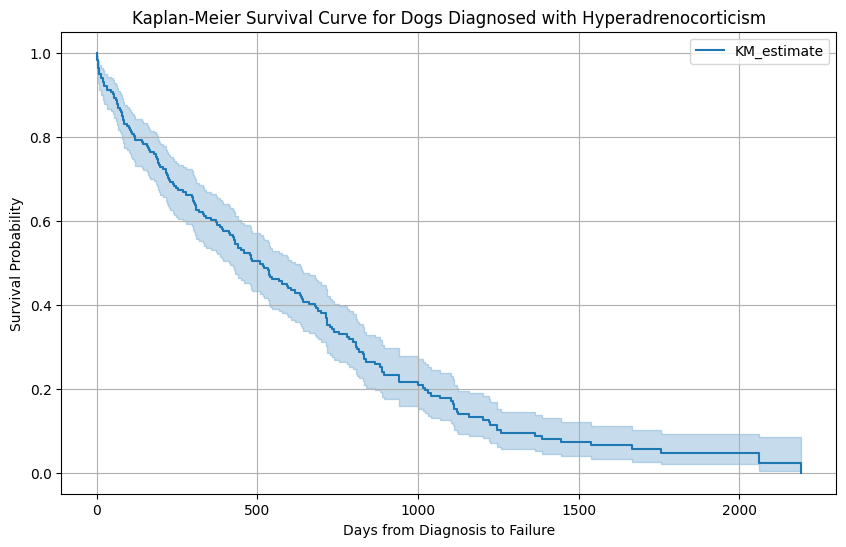

    Survival Probability    Days  Expected Survivors
10                   1.0     0.0                 219
9                    0.9    54.0                 197
8                    0.8   119.0                 175
7                    0.7   224.0                 153
6                    0.6   373.0                 131
5                    0.5   510.0                 110
4                    0.4   681.0                  88
3                    0.3   807.0                  66
2                    0.2  1023.0                  44
1                    0.1  1260.0                  22
0                    0.0  2192.0                   0
------------------------------------------------------------------------------
Median Survival Time for Dogs Diagnosed with Hyperadrenocorticism: 510.00 days


In [18]:
# Fitting the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=canine_subset['Days_Diagnosis_to_Failure'], event_observed=canine_subset['Died'])

# Plotting the Kaplan-Meier survival function
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for Dogs Diagnosed with Hyperadrenocorticism')
plt.xlabel('Days from Diagnosis to Failure')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Extracting survival probabilities and time points
survival_function = kmf.survival_function_
time_points = survival_function.index.values
survival_probabilities = survival_function.values.flatten()

# Calculating expected survivors at specific probabilities from 1.0 to 0.0
total_dogs = len(canine_subset)  # Total number of dogs
thresholds = [round(i * 0.1, 1) for i in range(11)]  # Creating [1.0, 0.9, ..., 0.0]

# Initializing a list to store results
results = []

for threshold in thresholds:
    # Finding the closest survival probability to the threshold
    closest_index = (survival_probabilities <= threshold).argmax()  # Getting index of first occurrence of <= threshold
    days_at_threshold = time_points[closest_index]
    expected_survivors = round(total_dogs * threshold)  # Rounding the expected survivors
    
    results.append({
        'Survival Probability': threshold,
        'Days': days_at_threshold,
        'Expected Survivors': expected_survivors
    })

# Converting results to a DataFrame for better display
results_df = pd.DataFrame(results)

# Sorting the DataFrame by Survival Probability in descending order
results_df.sort_values(by='Survival Probability', ascending=False, inplace=True)

# Printing the results table
print(results_df)

print("------------------------------------------------------------------------------")
# Calculating median survival time
median_survival_time = kmf.median_survival_time_
print(f"Median Survival Time for Dogs Diagnosed with Hyperadrenocorticism: {median_survival_time:.2f} days")

### Log Rank Tests

#### Based on Neutered Status

Log-rank test between Neutered and Non-neutered: p-value = 0.4999

Bonferroni-corrected significance threshold: 0.0500


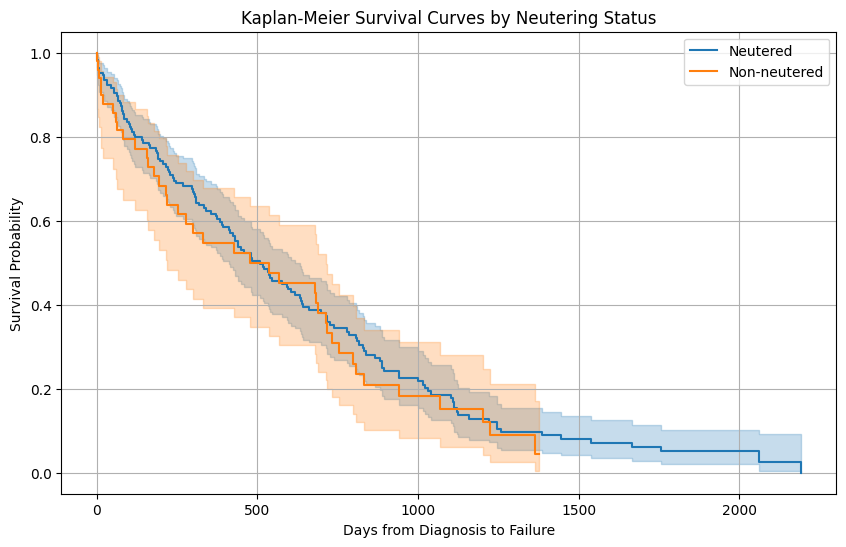


Expected Survival Probabilities for Neutered Dogs:
    Survival Probability    Days  Expected Survivors
0                    1.0     0.0                 169
1                    0.9    63.0                 152
2                    0.8   119.0                 135
3                    0.7   240.0                 118
4                    0.6   385.0                 101
5                    0.5   510.0                  84
6                    0.4   643.0                  68
7                    0.3   829.0                  51
8                    0.2  1031.0                  34
9                    0.1  1260.0                  17
10                   0.0  2192.0                   0

Expected Survival Probabilities for Non-neutered Dogs:
    Survival Probability    Days  Expected Survivors
0                    1.0     0.0                  50
1                    0.9    15.0                  45
2                    0.8    82.0                  40
3                    0.7   194.0            

In [19]:
# Grouping data based on Isneutered status
group1 = canine_subset[canine_subset['Isneutered'] == 'Yes']
group2 = canine_subset[canine_subset['Isneutered'] == 'No']

# Performing Log-Rank test between the two groups
results_isneutered = logrank_test(group1['Days_Diagnosis_to_Failure'], group2['Days_Diagnosis_to_Failure'], 
                                  event_observed_A=group1['Died'], event_observed_B=group2['Died'])

# Printing the p-value for the comparison
print(f"Log-rank test between Neutered and Non-neutered: p-value = {results_isneutered.p_value:.4f}")

# Calculating the Bonferroni-corrected threshold (only one comparison here)
alpha = 0.05
n_comparisons = 1  # Since we are only comparing two groups
bonferroni_threshold = alpha / n_comparisons
print(f"\nBonferroni-corrected significance threshold: {bonferroni_threshold:.4f}")

# Calculating the survival probabilities for both groups
kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

kmf_yes.fit(group1['Days_Diagnosis_to_Failure'], group1['Died'], label="Neutered")
kmf_no.fit(group2['Days_Diagnosis_to_Failure'], group2['Died'], label="Non-neutered")

# Plotting Kaplan-Meier survival curves
plt.figure(figsize=(10, 6))
kmf_yes.plot()
kmf_no.plot()

plt.title('Kaplan-Meier Survival Curves by Neutering Status')
plt.xlabel('Days from Diagnosis to Failure')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Defining the thresholds (from 1.0 to 0.0)
thresholds = [round(i * 0.1, 1) for i in range(11)][::-1]  # Creates [1.0, 0.9, ..., 0.0] in reverse order

# Initializing the lists to store results
results_yes = []
results_no = []

for threshold in thresholds:
    # For Neutered group
    closest_index_yes = (kmf_yes.survival_function_.values <= threshold).argmax()
    days_at_threshold_yes = kmf_yes.survival_function_.index[closest_index_yes]
    expected_survivors_yes = round(len(group1) * threshold)
    
    results_yes.append({
        'Survival Probability': threshold,
        'Days': days_at_threshold_yes,
        'Expected Survivors': expected_survivors_yes
    })
    
    # For Non-neutered group
    closest_index_no = (kmf_no.survival_function_.values <= threshold).argmax()
    days_at_threshold_no = kmf_no.survival_function_.index[closest_index_no]
    expected_survivors_no = round(len(group2) * threshold)
    
    results_no.append({
        'Survival Probability': threshold,
        'Days': days_at_threshold_no,
        'Expected Survivors': expected_survivors_no
    })

# Converting the results to DataFrames for better display
results_df_yes = pd.DataFrame(results_yes)
results_df_no = pd.DataFrame(results_no)

# Printing the results tables of survival probabilities
print("\nExpected Survival Probabilities for Neutered Dogs:")
print(results_df_yes)
print("\nExpected Survival Probabilities for Non-neutered Dogs:")
print(results_df_no)

#### Based on Purebreed Status

Log-rank test between Purebred and Crossbred: p-value = 0.6397

Bonferroni-corrected significance threshold: 0.0500


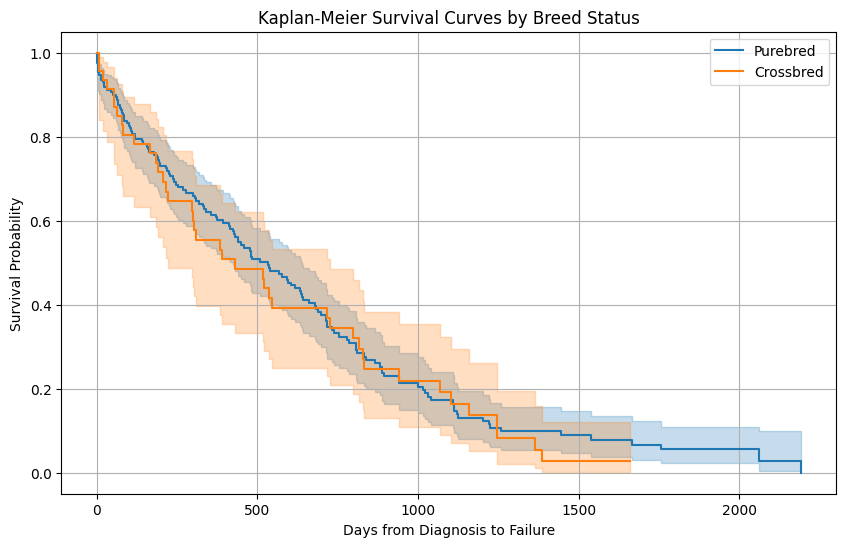


Expected Survival Probabilities for Purebred Dogs:
    Survival Probability    Days  Expected Survivors
0                    1.0     0.0                 172
1                    0.9    50.0                 155
2                    0.8   119.0                 138
3                    0.7   237.0                 120
4                    0.6   395.0                 103
5                    0.5   533.0                  86
6                    0.4   681.0                  69
7                    0.3   807.0                  52
8                    0.2  1015.0                  34
9                    0.1  1260.0                  17
10                   0.0  2192.0                   0

Expected Survival Probabilities for Crossbred Dogs:
    Survival Probability    Days  Expected Survivors
0                    1.0     0.0                  47
1                    0.9    54.0                  42
2                    0.8   118.0                  38
3                    0.7   208.0               

In [20]:
# Grouping data based on 'Purebreed_status'
group1 = canine_subset[canine_subset['Purebreed_status'] == 1]  # Purebred
group2 = canine_subset[canine_subset['Purebreed_status'] == 2]  # Crossbred

# Performing Log-Rank test between the two groups
results_purebreed = logrank_test(group1['Days_Diagnosis_to_Failure'], group2['Days_Diagnosis_to_Failure'], 
                                 event_observed_A=group1['Died'], event_observed_B=group2['Died'])

# Printing the p-value for the comparison
print(f"Log-rank test between Purebred and Crossbred: p-value = {results_purebreed.p_value:.4f}")

# Calculating the Bonferroni-corrected threshold (only one comparison here)
alpha = 0.05
n_comparisons = 1  # Since we are only comparing two groups
bonferroni_threshold = alpha / n_comparisons
print(f"\nBonferroni-corrected significance threshold: {bonferroni_threshold:.4f}")

# Calculating the survival probabilities for both groups
kmf_purebred = KaplanMeierFitter()
kmf_crossbred = KaplanMeierFitter()

kmf_purebred.fit(group1['Days_Diagnosis_to_Failure'], group1['Died'], label="Purebred")
kmf_crossbred.fit(group2['Days_Diagnosis_to_Failure'], group2['Died'], label="Crossbred")

# Plotting Kaplan-Meier survival curves
plt.figure(figsize=(10, 6))
kmf_purebred.plot()
kmf_crossbred.plot()

plt.title('Kaplan-Meier Survival Curves by Breed Status')
plt.xlabel('Days from Diagnosis to Failure')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Defining the thresholds (from 1.0 to 0.0)
thresholds = [round(i * 0.1, 1) for i in range(11)][::-1]  # Creates [1.0, 0.9, ..., 0.0] in reverse order

# Initializing the lists to store results
results_purebred = []
results_crossbred = []

for threshold in thresholds:
    # For Purebred group
    closest_index_purebred = (kmf_purebred.survival_function_.values <= threshold).argmax()
    days_at_threshold_purebred = kmf_purebred.survival_function_.index[closest_index_purebred]
    expected_survivors_purebred = round(len(group1) * threshold)
    
    results_purebred.append({
        'Survival Probability': threshold,
        'Days': days_at_threshold_purebred,
        'Expected Survivors': expected_survivors_purebred
    })
    
    # For Crossbred group
    closest_index_crossbred = (kmf_crossbred.survival_function_.values <= threshold).argmax()
    days_at_threshold_crossbred = kmf_crossbred.survival_function_.index[closest_index_crossbred]
    expected_survivors_crossbred = round(len(group2) * threshold)
    
    results_crossbred.append({
        'Survival Probability': threshold,
        'Days': days_at_threshold_crossbred,
        'Expected Survivors': expected_survivors_crossbred
    })

# Converting the results to DataFrames for better display
results_df_purebred = pd.DataFrame(results_purebred)
results_df_crossbred = pd.DataFrame(results_crossbred)

# Printing the results tables of survival probabilities
print("\nExpected Survival Probabilities for Purebred Dogs:")
print(results_df_purebred)
print("\nExpected Survival Probabilities for Crossbred Dogs:")
print(results_df_crossbred)

#### Based on treated with trilostane

Log-rank test between Treated and Not Treated with trilostane: p-value = 0.5896

Bonferroni-corrected significance threshold: 0.0500


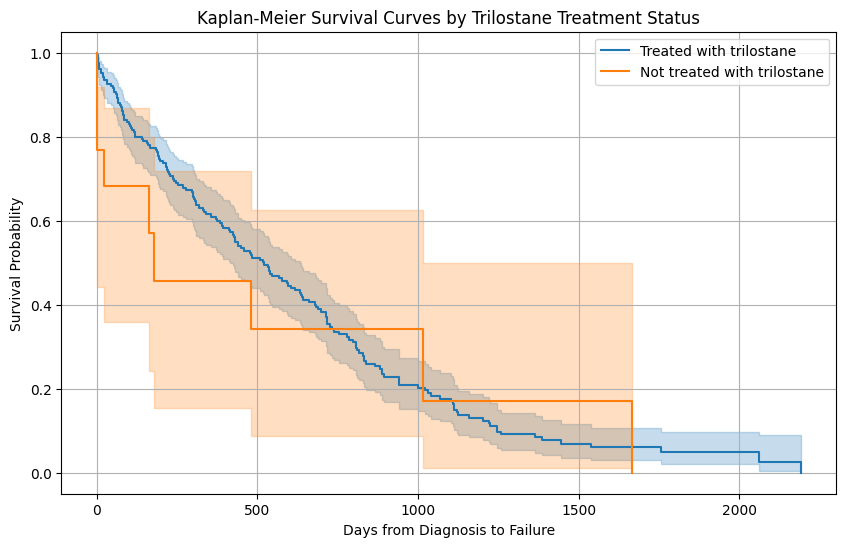


Expected Survival Probabilities for Dogs Treated with Trilostane:
    Survival Probability    Days  Expected Survivors
0                    1.0     0.0                 206
1                    0.9    63.0                 185
2                    0.8   119.0                 165
3                    0.7   240.0                 144
4                    0.6   376.0                 124
5                    0.5   520.0                 103
6                    0.4   683.0                  82
7                    0.3   807.0                  62
8                    0.2  1023.0                  41
9                    0.1  1245.0                  21
10                   0.0  2192.0                   0

Expected Survival Probabilities for Dogs Not Treated with Trilostane:
    Survival Probability    Days  Expected Survivors
0                    1.0     0.0                  13
1                    0.9     1.0                  12
2                    0.8     3.0                  10
3             

In [21]:
# Grouping data based on 'Treated with trilostane_7' status
group1 = canine_subset[canine_subset['Treated with trilostane_7'] == 1]  # Treated
group2 = canine_subset[canine_subset['Treated with trilostane_7'] == 2]  # Not treated

# Performing Log-Rank test between the two groups
results_trilostane = logrank_test(group1['Days_Diagnosis_to_Failure'], group2['Days_Diagnosis_to_Failure'], 
                                  event_observed_A=group1['Died'], event_observed_B=group2['Died'])

# Printing the p-value for the comparison
print(f"Log-rank test between Treated and Not Treated with trilostane: p-value = {results_trilostane.p_value:.4f}")

# Calculating the Bonferroni-corrected threshold (only one comparison here)
alpha = 0.05
n_comparisons = 1  # Since we are only comparing two groups
bonferroni_threshold = alpha / n_comparisons
print(f"\nBonferroni-corrected significance threshold: {bonferroni_threshold:.4f}")

# Calculating the survival probabilities for both groups
kmf_treated = KaplanMeierFitter()
kmf_not_treated = KaplanMeierFitter()

kmf_treated.fit(group1['Days_Diagnosis_to_Failure'], group1['Died'], label="Treated with trilostane")
kmf_not_treated.fit(group2['Days_Diagnosis_to_Failure'], group2['Died'], label="Not treated with trilostane")

# Plotting Kaplan-Meier survival curves
plt.figure(figsize=(10, 6))
kmf_treated.plot()
kmf_not_treated.plot()

plt.title('Kaplan-Meier Survival Curves by Trilostane Treatment Status')
plt.xlabel('Days from Diagnosis to Failure')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.show()

# Defining the thresholds (from 1.0 to 0.0)
thresholds = [round(i * 0.1, 1) for i in range(11)][::-1]  # Creates [1.0, 0.9, ..., 0.0] in reverse order

# Initializing the lists to store results
results_treated = []
results_not_treated = []

for threshold in thresholds:
    # For Treated group
    closest_index_treated = (kmf_treated.survival_function_.values <= threshold).argmax()
    days_at_threshold_treated = kmf_treated.survival_function_.index[closest_index_treated]
    expected_survivors_treated = round(len(group1) * threshold)
    
    results_treated.append({
        'Survival Probability': threshold,
        'Days': days_at_threshold_treated,
        'Expected Survivors': expected_survivors_treated
    })
    
    # For Not Treated group
    closest_index_not_treated = (kmf_not_treated.survival_function_.values <= threshold).argmax()
    days_at_threshold_not_treated = kmf_not_treated.survival_function_.index[closest_index_not_treated]
    expected_survivors_not_treated = round(len(group2) * threshold)
    
    results_not_treated.append({
        'Survival Probability': threshold,
        'Days': days_at_threshold_not_treated,
        'Expected Survivors': expected_survivors_not_treated
    })

# Converting the results to DataFrames for better display
results_df_treated = pd.DataFrame(results_treated)
results_df_not_treated = pd.DataFrame(results_not_treated)

# Printing the results tables of survival probabilities
print("\nExpected Survival Probabilities for Dogs Treated with Trilostane:")
print(results_df_treated)
print("\nExpected Survival Probabilities for Dogs Not Treated with Trilostane:")
print(results_df_not_treated)

#### Based on Breeds

In [22]:
# Counting the number of samples for each breed
breed_counts = canine_subset['Breed'].value_counts()
print(breed_counts)

# Filtering breeds with sufficient representation 
sufficient_breeds = breed_counts[breed_counts >= 10].index.tolist()
print("Breeds with sufficient representation:", sufficient_breeds)

Breed
Crossbreed                                                                                                   47
Terrier - Jack Russell (JRT)                                                                                 21
Terrier - Yorkshire (Yorkshire Terrier)                                                                      16
Bichon - Frise                                                                                               13
Terrier - Staffordshire Bull (unspecified) (Staffordshire Bull Terrier (unspecified))                        13
Terrier - West Highland White (WHWT) (West Highland White Terrier (WHWT))                                    12
Retriever - Labrador (Labrador Retriever)                                                                     8
Schnauzer                                                                                                     8
Spaniel - Cocker (unspecified) (Cocker Spaniel (unspecified))                                     

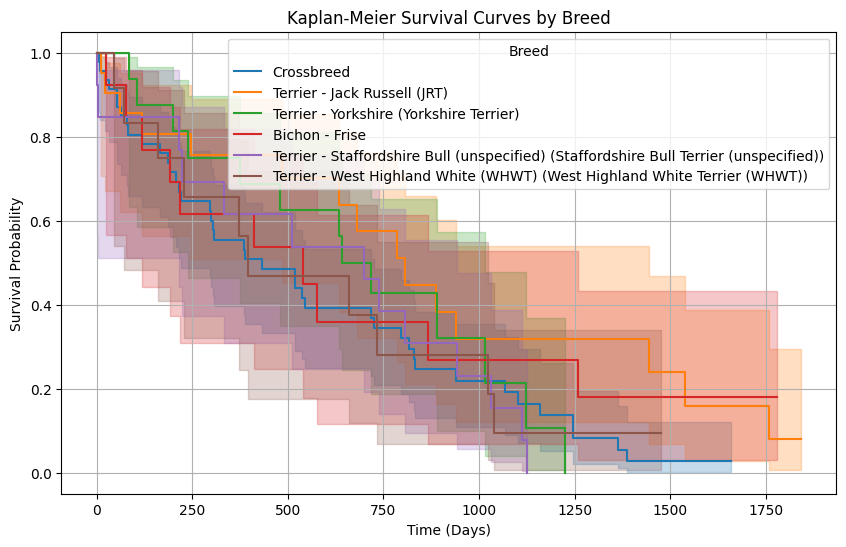

In [23]:
# Creating a dictionary to hold subsets for each breed
breed_data = {breed: canine_subset[canine_subset['Breed'] == breed] for breed in sufficient_breeds}

# Fitting and Plotting Kaplan-Meier curves for each breed
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for breed, data in breed_data.items():
    kmf.fit(data['Days_Diagnosis_to_Failure'], event_observed=data['Died'], label=breed)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Breed')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.legend(title='Breed')
plt.grid(True)
plt.show()

In [24]:
# Performing log-rank tests between pairs of breeds
breeds_to_compare = list(sufficient_breeds)  # List of breeds to compare
for i in range(len(breeds_to_compare)):
    for j in range(i + 1, len(breeds_to_compare)):
        group1 = breed_data[breeds_to_compare[i]]
        group2 = breed_data[breeds_to_compare[j]]
        
        results = logrank_test(
            group1['Days_Diagnosis_to_Failure'], 
            group2['Days_Diagnosis_to_Failure'], 
            event_observed_A=group1['Died'], 
            event_observed_B=group2['Died']
        )
        
        print(f"Log-Rank Test between {breeds_to_compare[i]} and {breeds_to_compare[j]}: p-value = {results.p_value}")

Log-Rank Test between Crossbreed and Terrier - Jack Russell (JRT): p-value = 0.03642641759435863
Log-Rank Test between Crossbreed and Terrier - Yorkshire (Yorkshire Terrier): p-value = 0.6692473130343376
Log-Rank Test between Crossbreed and Bichon - Frise: p-value = 0.36841829323395925
Log-Rank Test between Crossbreed and Terrier - Staffordshire Bull (unspecified) (Staffordshire Bull Terrier (unspecified)): p-value = 0.7709627160434211
Log-Rank Test between Crossbreed and Terrier - West Highland White (WHWT) (West Highland White Terrier (WHWT)): p-value = 0.8337970167715292
Log-Rank Test between Terrier - Jack Russell (JRT) and Terrier - Yorkshire (Yorkshire Terrier): p-value = 0.2577114515491709
Log-Rank Test between Terrier - Jack Russell (JRT) and Bichon - Frise: p-value = 0.5158772885275844
Log-Rank Test between Terrier - Jack Russell (JRT) and Terrier - Staffordshire Bull (unspecified) (Staffordshire Bull Terrier (unspecified)): p-value = 0.12143454232807871
Log-Rank Test between 

### Preprocessing - Part 2 : For CoxPH and Random Survival Forests

In [25]:
# Categorical columns summary function
def categorical_column_summary(df, column_name):
    column = df[column_name]
    unique_values = column.unique()
    value_counts = column.value_counts()
    null_count = column.isnull().sum()
    
    # Preparing the data for tabulation
    summary_data = {
        'Unique Values': unique_values,
        'Count': [value_counts.get(val, 0) for val in unique_values],
        'Percentage': [round(value_counts.get(val, 0) / len(column) * 100, 2) for val in unique_values]
    }
    
    # Creating the DataFrame for the column
    summary_df = pd.DataFrame(summary_data)
    
    print(f"\nSummary for Categorical Column: {column_name}")
    print(f"Total Entries: {len(column)}")
    print(f"Null Count: {null_count}")
    print(tabulate(summary_df, headers='keys', tablefmt='pretty', showindex=False))

# Continuous columns summary function
def continuous_column_summary(df, column_name):
    column = df[column_name]
    null_count = column.isnull().sum()
    
    summary_data = {
        'Statistic': ['Null Count', 'Total Entries', 'Mean', 'Median', 'Min', 'Max', 'Standard Deviation'],
        'Value': [
            null_count, 
            len(column), 
            round(column.mean(), 2), 
            round(column.median(), 2), 
            round(column.min(), 2), 
            round(column.max(), 2), 
            round(column.std(), 2)
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    print(f"\nSummary for Continuous Column: {column_name}")
    print(tabulate(summary_df, headers='keys', tablefmt='pretty', showindex=False))

# Categorical columns
cat_columns = [
    'Died','Neuro signs', 'Complications', 'Hypertensive_Yes4', 'Oversuppresion?',
    'Cortisol stayed <250', 'Cortisol went <40', 'Number_comorbidities',
    'comorb_UTI', 'comorb_dm', 'comorb_hypot', 'Sex', 'Isneutered',
    'BreedRelativeWeight', 'Purebreed_status', 'Changes to trilostane_6',
    'Stay_vs_stop', 'Treated with trilostane_7', 'Trilostane SID/BID_9'
]

# Continuous columns
cont_columns = [
    'Days_Diagnosis_to_Failure', 'Pre-ACTH', 'Post-ACTH', 'weight', 'Trilostane starting dose (mg/kg)_8',
    'Age_at_diagnosis(Years)', 'Time_suspicion_to_diagnosis(Days)'
]

# Generating the summaries for categorical columns
print("CATEGORICAL COLUMNS SUMMARY")
print("=" * 50)
for column in cat_columns:
    categorical_column_summary(canine_subset, column)

# Generating the summaries for continuous columns
print("\n\nCONTINUOUS COLUMNS SUMMARY")
print("=" * 50)
for column in cont_columns:
    continuous_column_summary(canine_subset, column)

CATEGORICAL COLUMNS SUMMARY

Summary for Categorical Column: Died
Total Entries: 219
Null Count: 0
+---------------+-------+------------+
| Unique Values | Count | Percentage |
+---------------+-------+------------+
|      0.0      | 40.0  |   18.26    |
|      1.0      | 179.0 |   81.74    |
+---------------+-------+------------+

Summary for Categorical Column: Neuro signs
Total Entries: 219
Null Count: 0
+---------------+-------+------------+
| Unique Values | Count | Percentage |
+---------------+-------+------------+
|      No       |  174  |   79.45    |
|      Yes      |  45   |   20.55    |
+---------------+-------+------------+

Summary for Categorical Column: Complications
Total Entries: 219
Null Count: 0
+---------------+-------+------------+
| Unique Values | Count | Percentage |
+---------------+-------+------------+
|    Unknown    |  169  |   77.17    |
|      Yes      |  50   |   22.83    |
+---------------+-------+------------+

Summary for Categorical Column: Hyperten

In [26]:
# Creating a list of columns to include in cox_data
columns_to_include = [
    # Clinical factors
    'Pre-ACTH', 'Post-ACTH', 'weight', 
    'Neuro signs', 'Complications', 'Hypertensive_Yes4', 'Oversuppresion?',
    'Cortisol stayed <250', 'Cortisol went <40', 'Number_comorbidities',
    'comorb_UTI', 'comorb_dm', 'comorb_hypot',
    
    # Demographic factors
    'Sex', 'Isneutered', 'BreedRelativeWeight', 'Purebreed_status',
    
    # Treatment-related factors
    'Stay_vs_stop', 'Treated with trilostane_7',
 
    # Time-related factors
    'Age_at_diagnosis(Years)', 'Time_suspicion_to_diagnosis(Days)',
    
    # Outcome and event indicator
    'Days_Diagnosis_to_Failure', 'Died'
]

# Copying the selected columns to cox_data
cox_data = canine_subset[columns_to_include].copy()

# Displaying the first few rows of cox_data to verify
print(cox_data.head())

# Print the column names of cox_data one by one
print("Column names in cox_data:")
for col in cox_data.columns:
    print(col)

# Print the number of columns
num_cols = len(cox_data.columns)
print("\nTotal number of columns in cox_data:", num_cols)

# Get the number of rows in cox_subset
num_rows = len(cox_data)
print("Number of rows in cox_subset:", num_rows)


   Pre-ACTH  Post-ACTH  weight Neuro signs Complications Hypertensive_Yes4  \
0       0.0        0.0    7.55          No       Unknown           Unknown   
1       0.0        0.0    7.20          No       Unknown           Unknown   
2     267.0      922.0   12.50          No       Unknown           Unknown   
3       0.0        0.0   19.00          No       Unknown           Unknown   
4     145.0      684.0   34.25          No           Yes               Yes   

  Oversuppresion? Cortisol stayed <250 Cortisol went <40 Number_comorbidities  \
0             Yes                  Yes               Yes                  0.0   
1             Yes              Unknown           Unknown                  1.0   
2             Yes                  Yes                No                  3.0   
3             Yes                   No                No                  0.0   
4             Yes                  Yes               Yes                  1.0   

   ...     Sex Isneutered BreedRelativeWeigh

In [27]:
# Encoding Sex: Male as 0 and Female as 1
cox_data['Sex'] = (cox_data['Sex'].str.lower() == 'female').astype(int)

# Displaying the unique values and their counts for the new encoded columns
print("Encoded Sex column:")
print(cox_data['Sex'].value_counts(dropna=False))

# Checking for remaining null values
print("\nNull values in encoded columns:")
print(cox_data[['Sex']].isnull().sum())

# Get the number of rows in cox_subset
num_rows = len(cox_data)
print("Number of rows in cox_subset:", num_rows)


Encoded Sex column:
Sex
0    115
1    104
Name: count, dtype: int64

Null values in encoded columns:
Sex    0
dtype: int64
Number of rows in cox_subset: 219


In [28]:
# Converting specified columns from float to int, keeping NaNs as is
cox_data['Died'] = cox_data['Died'].astype('Int64')
print("Died unique values:", cox_data['Died'].unique())

cox_data['Number_comorbidities'] = cox_data['Number_comorbidities'].astype('Int64')
print("Number_comorbidities unique values:", cox_data['Number_comorbidities'].unique())

cox_data['BreedRelativeWeight'] = cox_data['BreedRelativeWeight'].astype('Int64')
print("BreedRelativeWeight unique values:", cox_data['BreedRelativeWeight'].unique())

cox_data['Purebreed_status'] = cox_data['Purebreed_status'].astype('Int64')
print("Purebreed_status unique values:", cox_data['Purebreed_status'].unique())

cox_data['Stay_vs_stop'] = cox_data['Stay_vs_stop'].astype('Int64')
print("Stay_vs_stop unique values:", cox_data['Stay_vs_stop'].unique())

cox_data['Treated with trilostane_7'] = cox_data['Treated with trilostane_7'].astype('Int64')
print("Treated with trilostane_7 unique values:", cox_data['Treated with trilostane_7'].unique())

# Get the number of rows in cox_subset
num_rows = len(cox_data)
print("Number of rows in cox_subset:", num_rows)

Died unique values: <IntegerArray>
[0, 1]
Length: 2, dtype: Int64
Number_comorbidities unique values: <IntegerArray>
[0, 1, 3, 2, 4, 5]
Length: 6, dtype: Int64
BreedRelativeWeight unique values: <IntegerArray>
[1, 2, 4, 3]
Length: 4, dtype: Int64
Purebreed_status unique values: <IntegerArray>
[1, 2]
Length: 2, dtype: Int64
Stay_vs_stop unique values: <IntegerArray>
[1, 2]
Length: 2, dtype: Int64
Treated with trilostane_7 unique values: <IntegerArray>
[1, 2]
Length: 2, dtype: Int64
Number of rows in cox_subset: 219


In [29]:
# Suppressing specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Encoding Neuro_signs: No as 0, Yes as 1
cox_data['Neuro signs'] = cox_data['Neuro signs'].replace({'Yes': 1, 'No': 0})
print("Neuro_signs unique values:", cox_data['Neuro signs'].unique())

# Encoding Complications: No as 0, Yes as 1
cox_data['Complications'] = cox_data['Complications'].replace({'Yes': 1, 'Unknown': 2})
print("Complications unique values:", cox_data['Complications'].unique())

# Encoding Hypertensive_Yes4: No as 0, Yes as 1
cox_data['Hypertensive_Yes4'] = cox_data['Hypertensive_Yes4'].replace({'Yes': 1, 'No': 0, 'Unknown': 2})
print("Hypertensive_Yes4 unique values:", cox_data['Hypertensive_Yes4'].unique())

# Encoding Oversuppresion: No as 0, Yes as 1
cox_data['Oversuppresion?'] = cox_data['Oversuppresion?'].replace({'Yes': 1, 'No': 0})
print("Oversuppresion unique values:", cox_data['Oversuppresion?'].unique())

# Encoding Cortisol stayed <250: No as 0, Yes as 1
cox_data['Cortisol stayed <250'] = cox_data['Cortisol stayed <250'].replace({'Yes': 1, 'No': 0, 'Unknown': 2})
print("Cortisol stayed <250 unique values:", cox_data['Cortisol stayed <250'].unique())

# Encoding Cortisol went <40: No as 0, Yes as 1
cox_data['Cortisol went <40'] = cox_data['Cortisol went <40'].replace({'Yes': 1, 'No': 0, 'Unknown': 2})
print("Cortisol went <40 unique values:", cox_data['Cortisol went <40'].unique())

# Encoding comorb_UTI: No as 0, Yes as 1
cox_data['comorb_UTI'] = cox_data['comorb_UTI'].replace({'Yes': 1, 'No': 0})
print("comorb_UTI unique values:", cox_data['comorb_UTI'].unique())

# Encoding comorb_dm: No as 0, Yes as 1
cox_data['comorb_dm'] = cox_data['comorb_dm'].replace({'Yes': 1, 'No': 0})
print("comorb_dm unique values:", cox_data['comorb_dm'].unique())

# Encoding comorb_hypot: No as 0, Yes as 1
cox_data['comorb_hypot'] = cox_data['comorb_hypot'].replace({'Yes': 1, 'No': 0})
print("comorb_hypot unique values:", cox_data['comorb_hypot'].unique())

# Encoding Isneutered: No as 0, Yes as 1
cox_data['Isneutered'] = cox_data['Isneutered'].replace({'Yes': 1, 'No': 0})
print("Isneutered unique values:", cox_data['Isneutered'].unique())

# Get the number of rows in cox_subset
num_rows = len(cox_data)
print("Number of rows in cox_subset:", num_rows)

# 'Changes to trilostane_6','Trilostane SID/BID_9' 'Trilostane starting dose (mg/kg)_8' multicollinearity

Neuro_signs unique values: [0, 1]
Categories (2, int64): [0, 1]
Complications unique values: [2, 1]
Categories (2, int64): [2, 1]
Hypertensive_Yes4 unique values: [2, 1, 0]
Categories (3, int64): [0, 2, 1]
Oversuppresion unique values: [1, 0]
Categories (2, int64): [0, 1]
Cortisol stayed <250 unique values: [1, 2, 0]
Categories (3, int64): [0, 2, 1]
Cortisol went <40 unique values: [1, 2, 0]
Categories (3, int64): [0, 2, 1]
comorb_UTI unique values: [0, 1]
Categories (2, int64): [0, 1]
comorb_dm unique values: [0, 1]
Categories (2, int64): [0, 1]
comorb_hypot unique values: [0, 1]
Categories (2, int64): [0, 1]
Isneutered unique values: [1, 0]
Categories (2, int64): [0, 1]
Number of rows in cox_subset: 219


In [30]:
# Printing the column names of cox_data 
print("Column names in cox_data:")
for col in cox_data.columns:
    print(col)

# Printing the number of columns
num_cols = len(cox_data.columns)
print("\nTotal number of columns in cox_data:", num_cols)
print(cox_data.head(2))

# Getting the number of rows in cox_subset
num_rows = len(cox_data)
print("Number of rows in cox_subset:", num_rows)

Column names in cox_data:
Pre-ACTH
Post-ACTH
weight
Neuro signs
Complications
Hypertensive_Yes4
Oversuppresion?
Cortisol stayed <250
Cortisol went <40
Number_comorbidities
comorb_UTI
comorb_dm
comorb_hypot
Sex
Isneutered
BreedRelativeWeight
Purebreed_status
Stay_vs_stop
Treated with trilostane_7
Age_at_diagnosis(Years)
Time_suspicion_to_diagnosis(Days)
Days_Diagnosis_to_Failure
Died

Total number of columns in cox_data: 23
   Pre-ACTH  Post-ACTH  weight Neuro signs Complications Hypertensive_Yes4  \
0       0.0        0.0    7.55           0             2                 2   
1       0.0        0.0    7.20           0             2                 2   

  Oversuppresion? Cortisol stayed <250 Cortisol went <40  \
0               1                    1                 1   
1               1                    2                 2   

   Number_comorbidities  ... Sex Isneutered BreedRelativeWeight  \
0                     0  ...   0          1                   1   
1                     1

#### Subset : final_cox_data is used for CoxPH Models

In [31]:
# Preparing the DataFrame for fitting CoxPH Model
final_cox_data = cox_data[['Days_Diagnosis_to_Failure', 
        'Died','Neuro signs', 'Complications', 'Hypertensive_Yes4', 'Oversuppresion?',
        'Cortisol stayed <250', 'Cortisol went <40', 'Number_comorbidities',
        'comorb_UTI', 'comorb_dm', 'comorb_hypot', 'Sex', 'Isneutered',
        'BreedRelativeWeight', 'Purebreed_status', 
        'Stay_vs_stop', 'Treated with trilostane_7', 'Pre-ACTH', 'Post-ACTH', 'weight', 
        'Age_at_diagnosis(Years)', 'Time_suspicion_to_diagnosis(Days)']]

# Getting the number of rows in cox_subset
num_rows = len(final_cox_data)
print("Number of rows in cox_subset:", num_rows)
    
# Creating an instance of the CoxPHFitter
cph = CoxPHFitter()  
cph.fit(final_cox_data, duration_col='Days_Diagnosis_to_Failure', event_col='Died')

# Printing the summary of the model
cph.print_summary()

Number of rows in cox_subset: 219


<lifelines.CoxPHFitter: fitted with 219 total observations, 40 right-censored observations>
             duration col = 'Days_Diagnosis_to_Failure'
                event col = 'Died'
      baseline estimation = breslow
   number of observations = 219
number of events observed = 179
   partial log-likelihood = -766.83
         time fit was run = 2024-11-23 18:25:33 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
Neuro signs                        0.49      1.64      0.20            0.10            0.89                1.10                2.43
Complications                     -0.14      0.87      0.30           -0.72            0.44                0.49                1.55
Hypertensive_Yes4                 -0.13      0.88      0.16           -0.44            0.19                0.64                1.21
Oversuppresion?                   -0.42      0.65      0.24           -0.90            0.05                0.41                1.05
Cortisol stayed <250               0.37      1.45      0.23           -0.09            0.83                0.91                2.29
Cortisol went <40                 -0.01      0.99      0.18           -0.36            0.34                0.70                1.41
Number_comorbidities              -0.19      0.82      0.10           -0.39            0.01                0.68                1.01
comorb_UTI                         0.92      2.50      0.28            0.37            1.46                1.45                4.30
comorb_dm                          0.21      1.23      0.33           -0.45            0.87                0.64                2.38
comorb_hypot                      -0.39      0.67      0.54           -1.45            0.66                0.23                1.94
Sex                               -0.06      0.94      0.17           -0.40            0.28                0.67                1.33
Isneutered                        -0.11      0.89      0.20           -0.50            0.27                0.61                1.31
BreedRelativeWeight               -0.11      0.89      0.13           -0.36            0.14                0.70                1.14
Purebreed_status                   0.20      1.22      0.33           -0.45            0.85                0.64                2.33
Stay_vs_stop                       0.16      1.18      0.22           -0.27            0.59                0.76                1.81
Treated with trilostane_7         -0.35      0.70      0.46           -1.26            0.55                0.28                1.74
Pre-ACTH                           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Post-ACTH                         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
weight                             0.01      1.01      0.01           -0.00            0.03                1.00                1.03
Age_at_diagnosis(Years)            0.16      1.18      0.04            0.09            0.24                1.09                1.27
Time_suspicion_to_diagnosis(Days) -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                                   cmp to     z      p  -log2(p)
covariate                                                       
Neuro signs                          0.00  2.45   0.01      6.12
Complications                        0.00 -0.48   0.63      0.67
Hypertensive_Yes4                    0.00 -0.79   0.43      1.21
Oversuppresion?                      0.00 -1.75   0.08      3.63
Cortisol stayed <250                 0.00  1.58   0.11      3.12
Cortisol went <40                    0.00 -0.05   0.96      0.06
Number_comorbidities                 0.00 -1.91   0.06      4.15
co


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lin

[[<Axes: xlabel='rank-transformed time\n(p=0.1050)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1157)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4023)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3914)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5798)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6410)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6326)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6293)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3914)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4004)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1004)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1057)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3749)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3740)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8431)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8348)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1995)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2228)'>],
 [<Axes: xlabel='rank-transformed tim

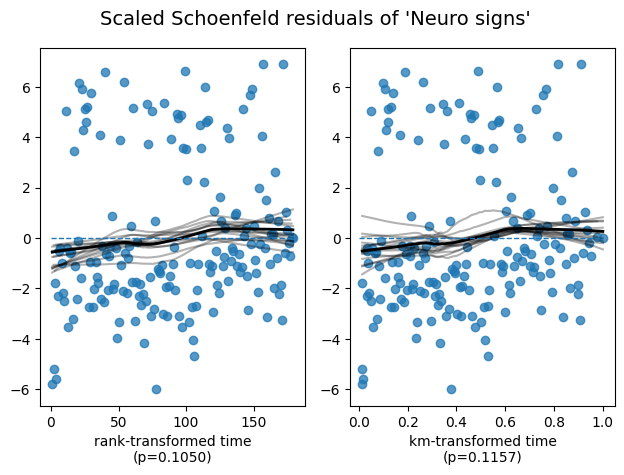

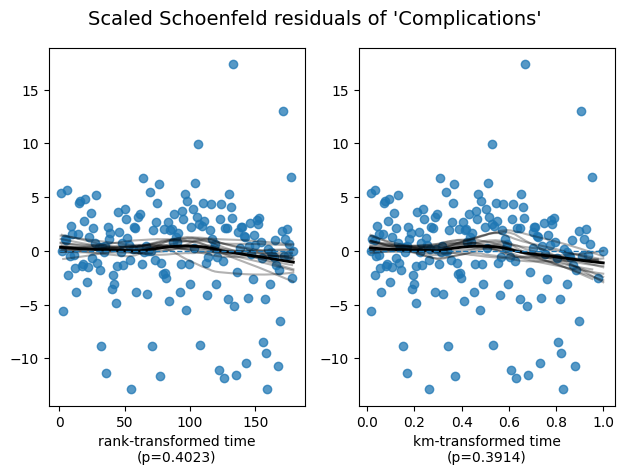

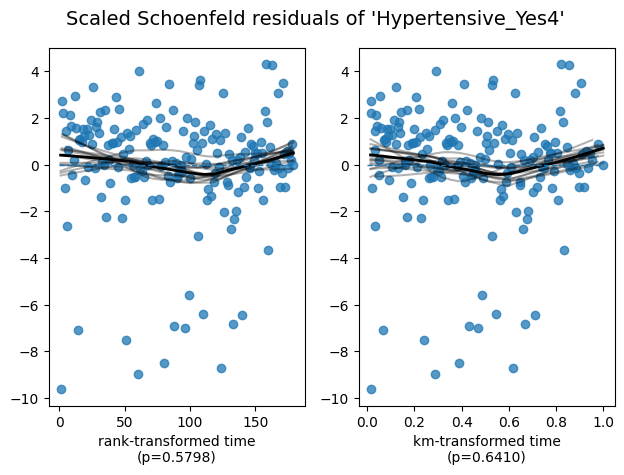

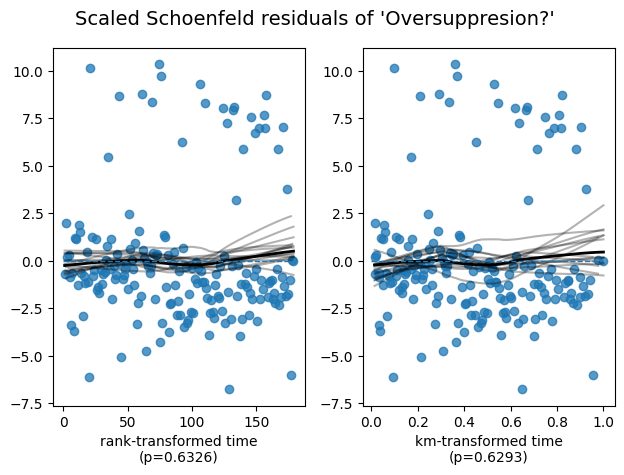

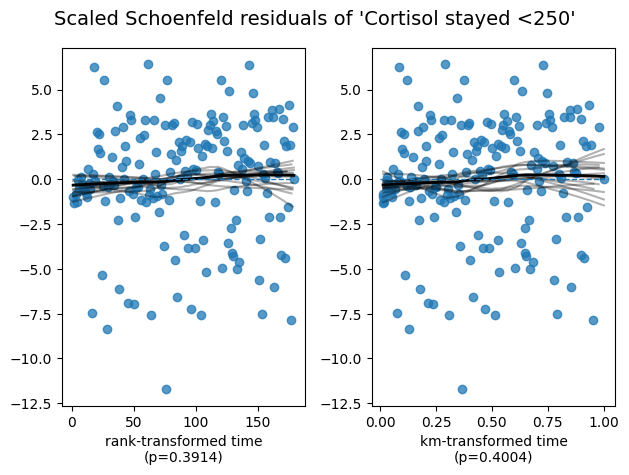

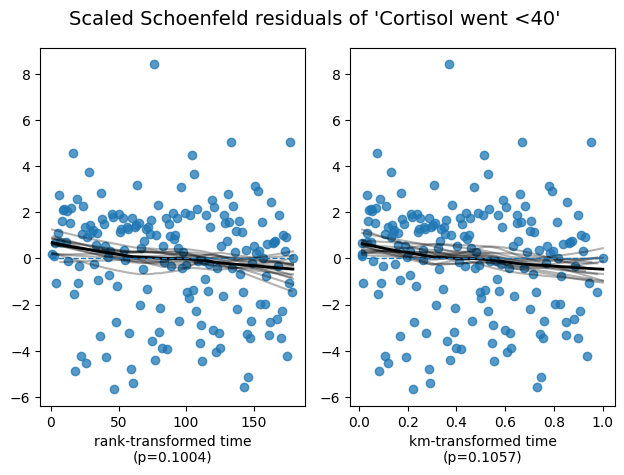

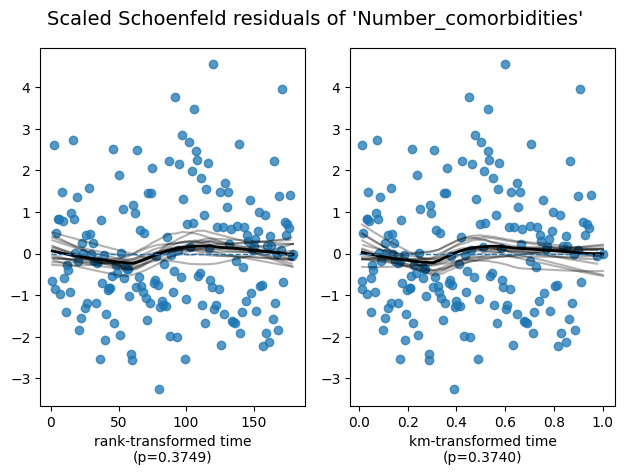

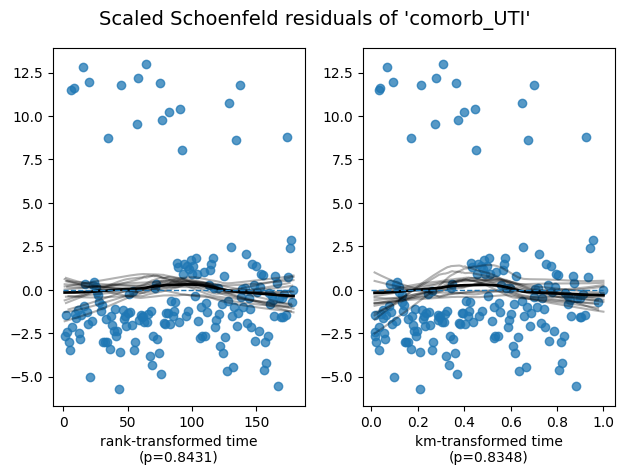

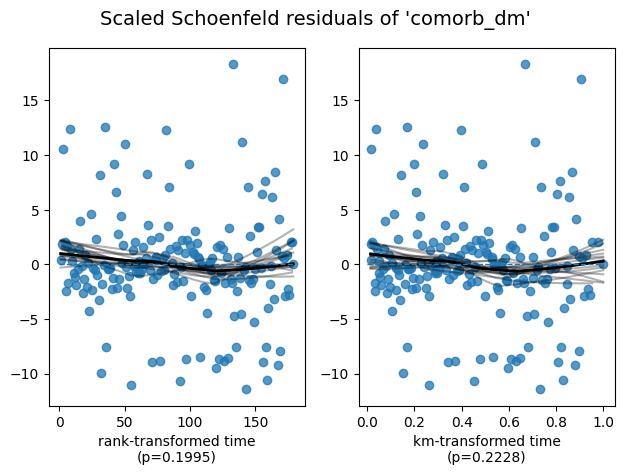

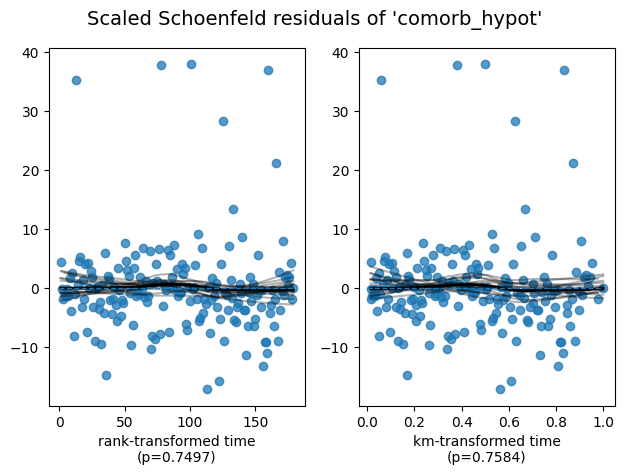

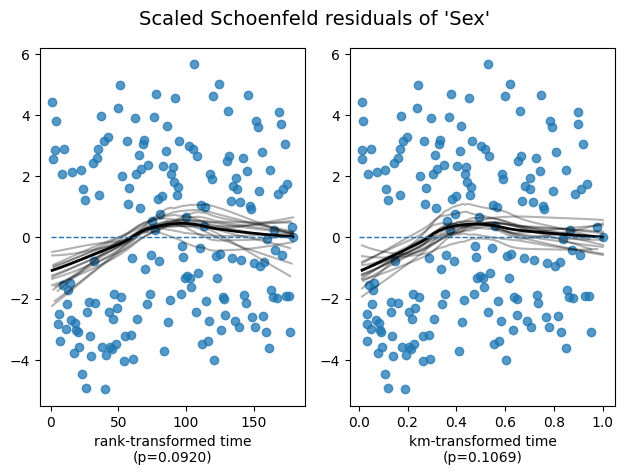

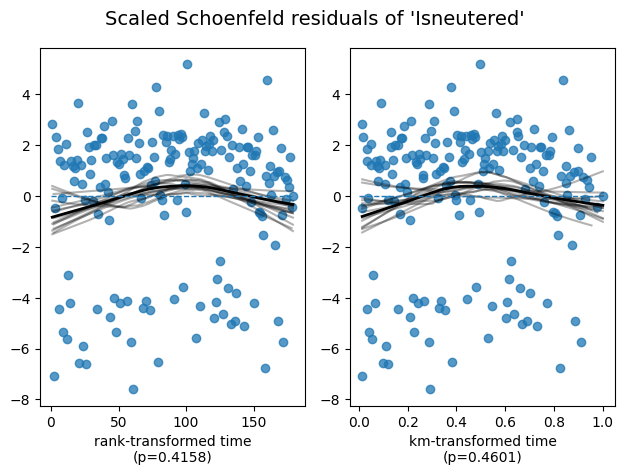

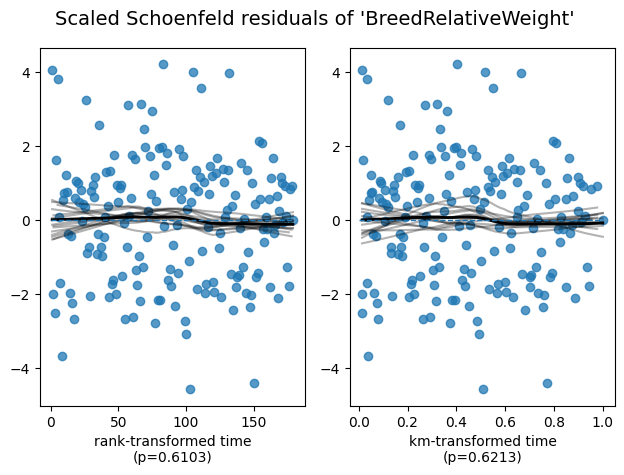

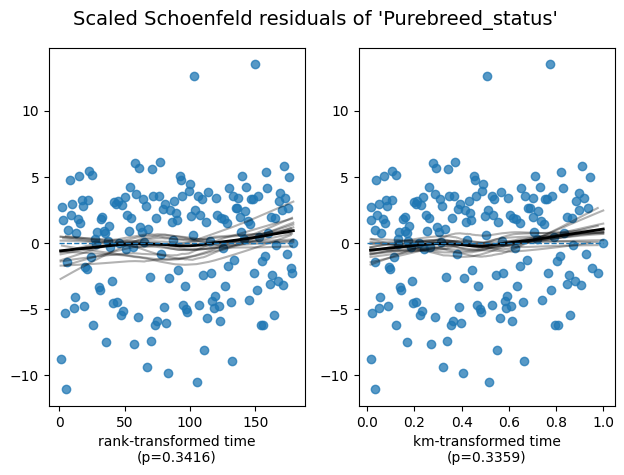

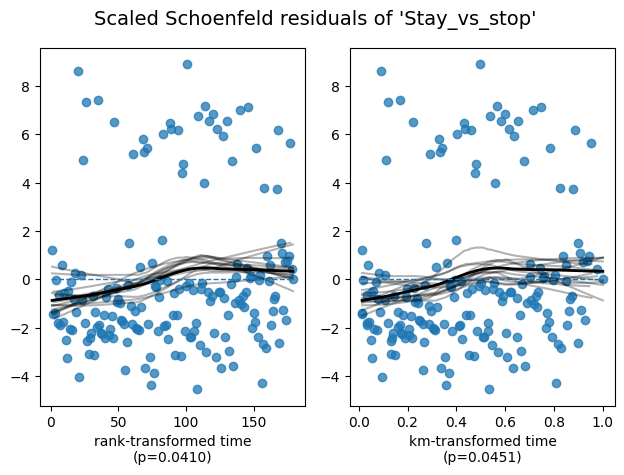

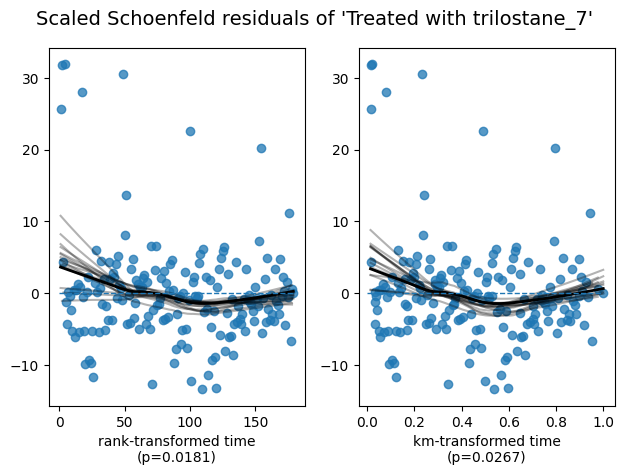

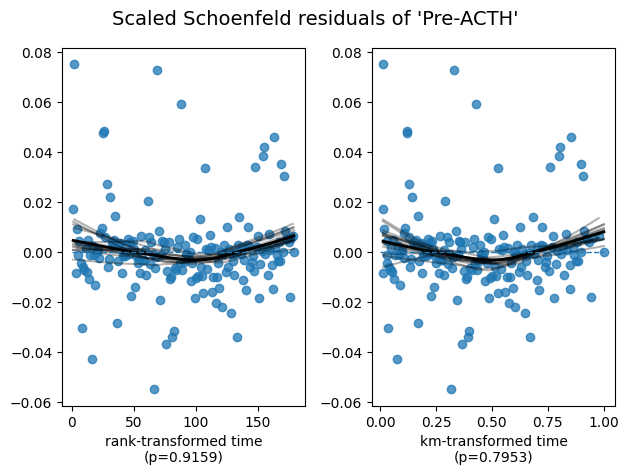

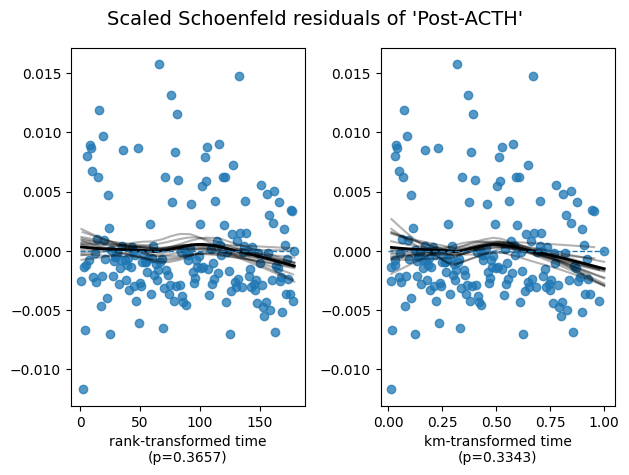

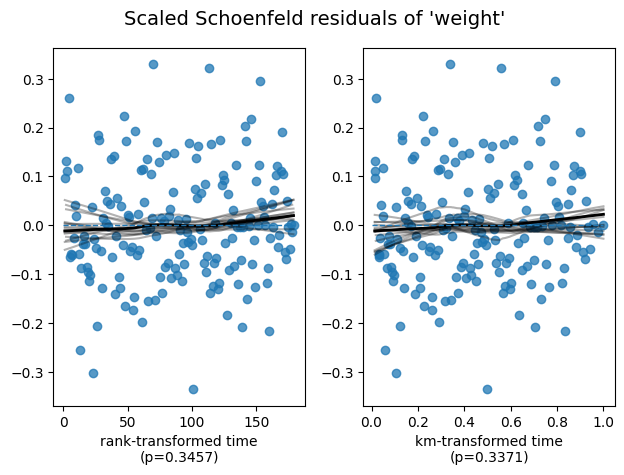

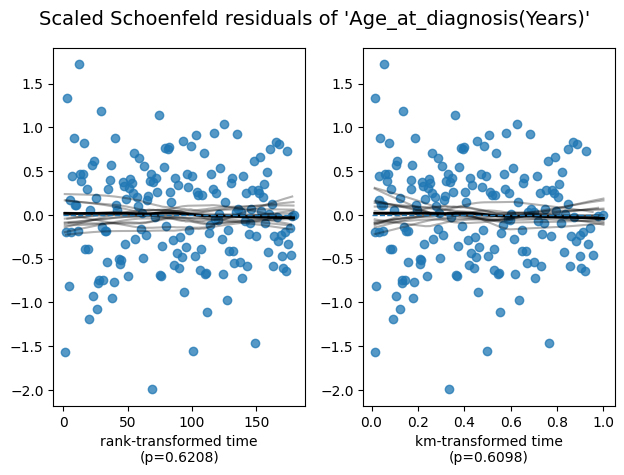

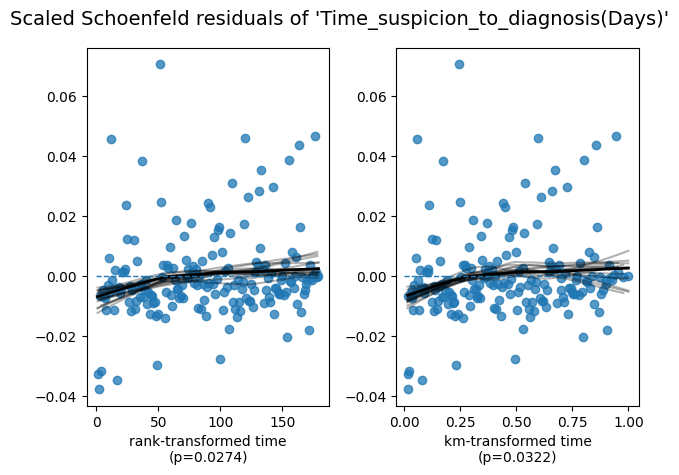

In [32]:
mpl.rcParams['figure.max_open_warning'] = 50
# Check proportional hazards assumption
cph.check_assumptions(final_cox_data, show_plots=True)

Proportional Hazards Assumption is Satisfied: The absence of any systematic trend in the residuals implies that the proportional hazards assumption is met. This is good news as it validates that the model is correctly specified in terms of the proportional hazards assumption.

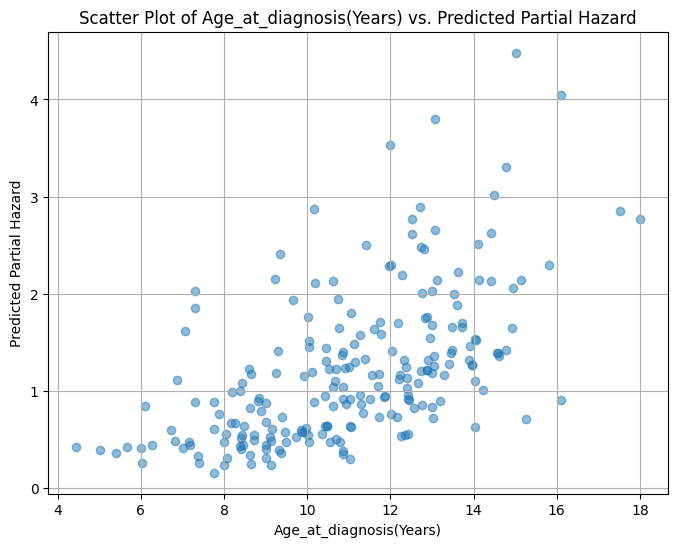

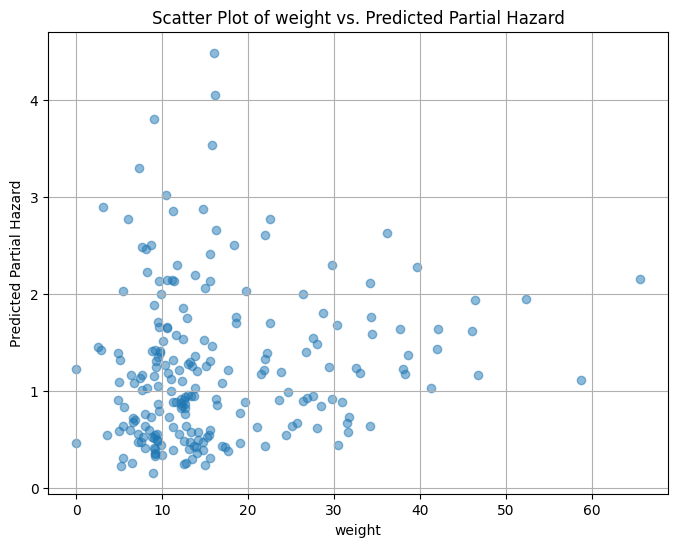

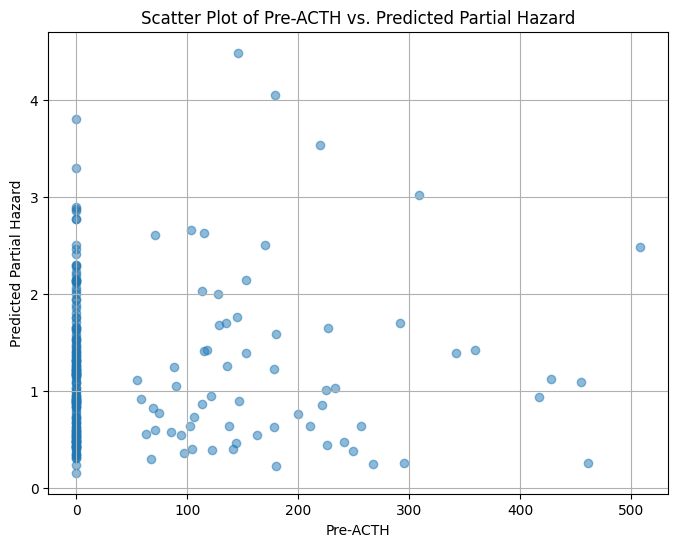

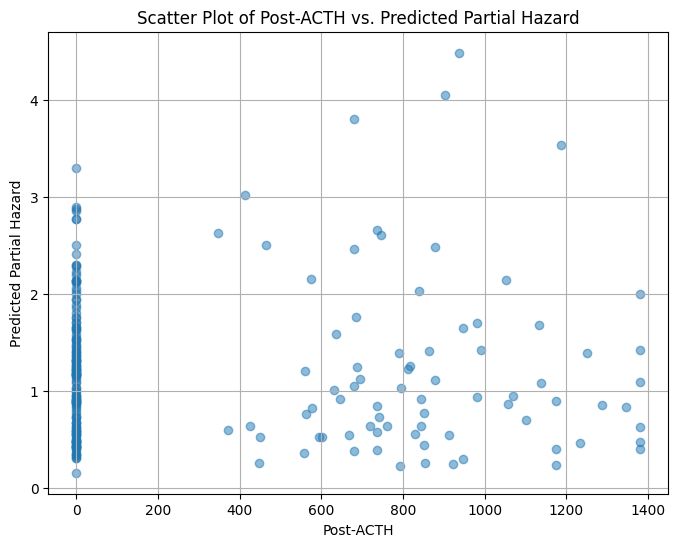

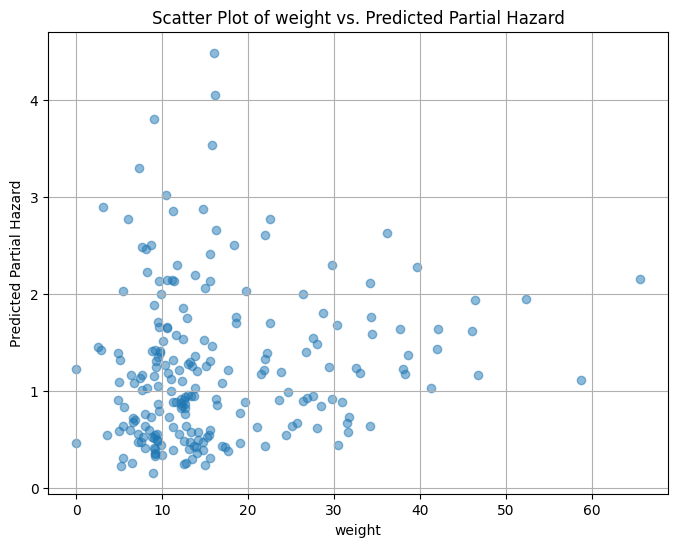

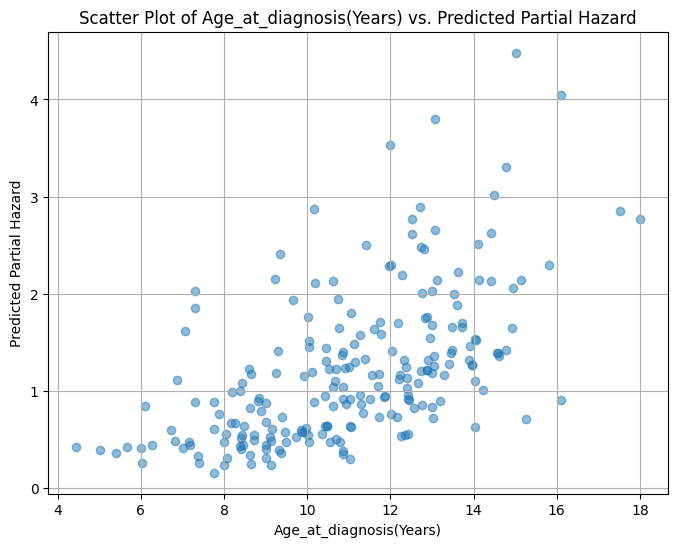

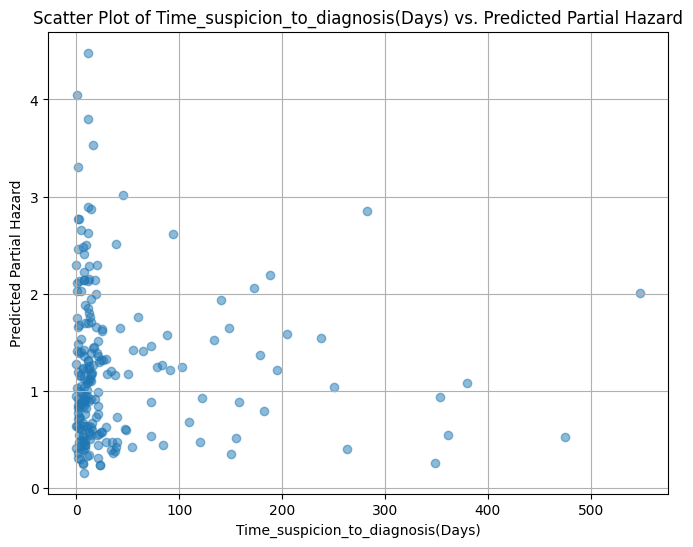

In [33]:
cph = CoxPHFitter()
cph.fit(final_cox_data, duration_col='Days_Diagnosis_to_Failure', event_col='Died')

# Calculating the predicted partial hazards for each individual
partial_hazards = cph.predict_partial_hazard(final_cox_data)

# Plotting for each continuous variable
continuous_vars = ['Age_at_diagnosis(Years)', 'weight', 'Pre-ACTH', 'Post-ACTH', 'weight', 
        'Age_at_diagnosis(Years)', 'Time_suspicion_to_diagnosis(Days)' ]  

for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    plt.scatter(final_cox_data[var], partial_hazards, alpha=0.5)
    plt.title(f'Scatter Plot of {var} vs. Predicted Partial Hazard')
    plt.xlabel(var)
    plt.ylabel('Predicted Partial Hazard')
    plt.grid(True)
    plt.show()

### CoxPH for Comorbities
#### Subset : canine_comorb is used for the Analysis

In [34]:
# Creating a new DataFrame for comorbidities
canine_comorb = pd.DataFrame()

# Converting the categorical variables to binary
canine_comorb['comorb_UTI'] = canine_subset['comorb_UTI'].map({'Yes': 1, 'No': 0})
canine_comorb['comorb_dm'] = canine_subset['comorb_dm'].map({'Yes': 1, 'No': 0})
canine_comorb['comorb_hypot'] = canine_subset['comorb_hypot'].map({'Yes': 1, 'No': 0})
canine_comorb['Number_comorbidities'] = canine_subset['Number_comorbidities']
canine_comorb['Days_Diagnosis_to_Failure'] = canine_subset['Days_Diagnosis_to_Failure']
canine_comorb['Died'] = canine_subset['Died']

# Displaying the modified DataFrame
print(canine_comorb[['comorb_UTI','comorb_dm','comorb_hypot']])

# Displaying the modified DataFrame
print(canine_subset[['comorb_UTI','comorb_dm','comorb_hypot']])

print("------------------------------------")
print(canine_comorb.head())

    comorb_UTI comorb_dm comorb_hypot
0            0         0            0
1            0         0            0
2            0         1            0
3            0         0            0
4            1         0            0
..         ...       ...          ...
214          0         0            0
215          0         0            0
216          0         0            0
217          0         0            0
218          0         0            0

[219 rows x 3 columns]
    comorb_UTI comorb_dm comorb_hypot
0           No        No           No
1           No        No           No
2           No       Yes           No
3           No        No           No
4          Yes        No           No
..         ...       ...          ...
214         No        No           No
215         No        No           No
216         No        No           No
217         No        No           No
218         No        No           No

[219 rows x 3 columns]
------------------------------------
  c

In [35]:
# Checking the data types
print("Data types before fitting:")
print(canine_comorb.dtypes)

# Convert all categorical columns to numeric
for col in canine_comorb.select_dtypes(include=['category']).columns:
    canine_comorb[col] = canine_comorb[col].cat.codes  # Convert categorical to numeric
    
# Checking the data types
print("Data types after fitting:")
print(canine_comorb.dtypes)

Data types before fitting:
comorb_UTI                   category
comorb_dm                    category
comorb_hypot                 category
Number_comorbidities         category
Days_Diagnosis_to_Failure       int64
Died                         category
dtype: object
Data types after fitting:
comorb_UTI                    int8
comorb_dm                     int8
comorb_hypot                  int8
Number_comorbidities          int8
Days_Diagnosis_to_Failure    int64
Died                          int8
dtype: object


In [36]:
# Fit multivariate model including all comorbidities and number of comorbidities
cph.fit(canine_comorb[['Days_Diagnosis_to_Failure', 'Died', 
                        'comorb_UTI', 'comorb_dm', 
                        'comorb_hypot', 'Number_comorbidities']], 
        duration_col='Days_Diagnosis_to_Failure', event_col='Died')

print("Multivariate analysis including all comorbidities:")
cph.print_summary()

Multivariate analysis including all comorbidities:


<lifelines.CoxPHFitter: fitted with 219 total observations, 40 right-censored observations>
             duration col = 'Days_Diagnosis_to_Failure'
                event col = 'Died'
      baseline estimation = breslow
   number of observations = 219
number of events observed = 179
   partial log-likelihood = -790.24
         time fit was run = 2024-11-23 18:26:10 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
comorb_UTI            0.60      1.82      0.25            0.10            1.09                1.11                2.97
comorb_dm             0.02      1.02      0.25           -0.47            0.51                0.62                1.66
comorb_hypot          0.10      1.11      0.42           -0.73            0.93                0.48                2.53
Number_comorbidities -0.10      0.90      0.08           -0.26            0.05                0.77                1.06

                      cmp to     z    p  -log2(p)
covariate                                        
comorb_UTI              0.00  2.38 0.02      5.84
comorb_dm               0.00  0.07 0.94      0.08
comorb_hypot            0.00  0.24 0.81      0.30
Number_comorbidities    0.00 -1.29 0.20      2.34
---
Concordance = 0.57
Partial AIC = 1588.49
log-likelihood ratio test = 6.62 on 4 df
-log2(p) of ll-ratio test = 2.67


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 219 total observations, 40 right-censored observations>
         test_name = proportional_hazard_test

---
                           test_statistic      p  -log2(p)
Number_comorbidities km              9.92 <0.005      9.26
                     rank           10.21 <0.005      9.48
comorb_UTI           km              0.05   0.82      0.28
                     rank            0.05   0.83      0.27
comorb_dm            km              0.43   0.51      0.97
                     rank            0.57   0.45      1.15
comorb_hypot         km              0.06   0.81      0.31
                     rank            0.04   0.84      0.26



1. Variable 'Number_comorbidities' failed the non-proportional test: p-value is 0.0014.

   Advice 1: the functional form of the variable 'Number_comorbidities' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Number_comorbidities' using pd.cut, and then specify it in
`strata=['Number_comorbidities', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_no

[[<Axes: xlabel='rank-transformed time\n(p=0.8276)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8243)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4517)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5106)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8377)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8063)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0014)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0016)'>]]

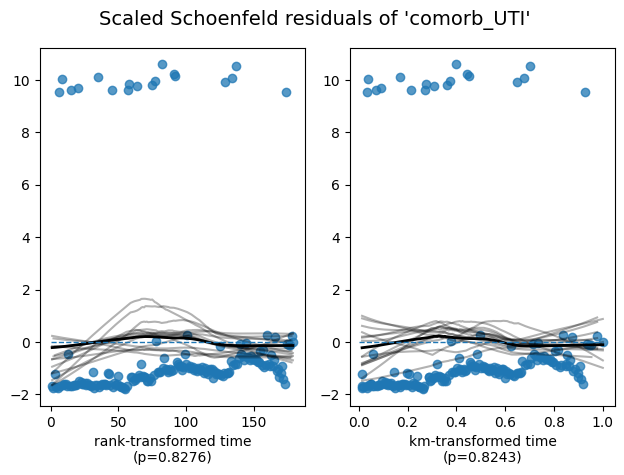

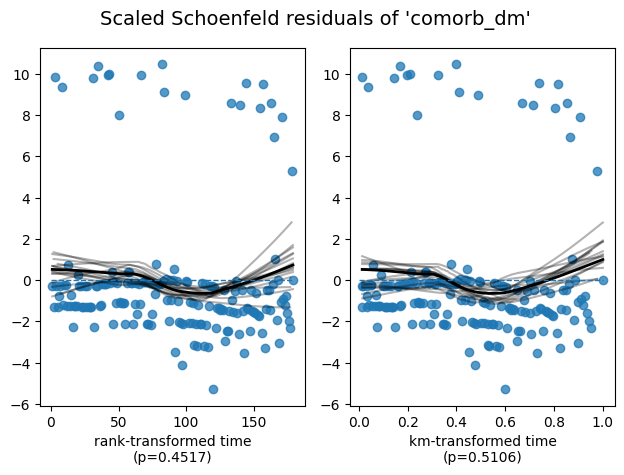

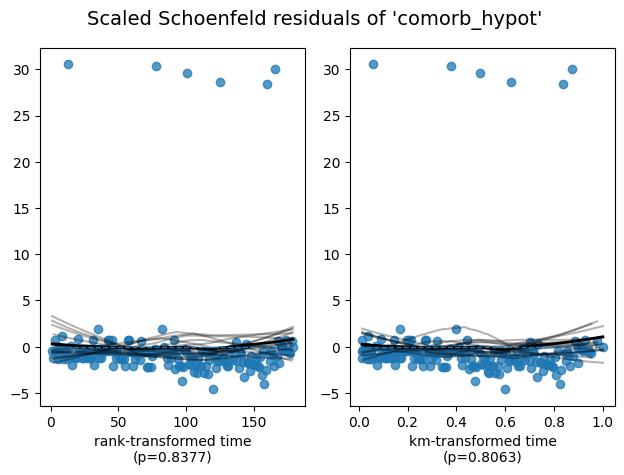

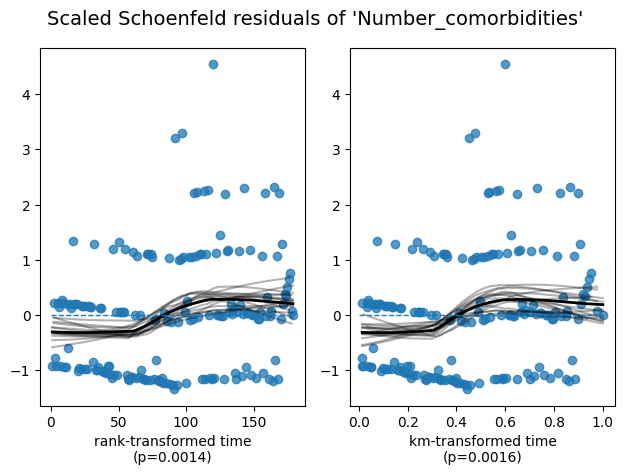

In [37]:
mpl.rcParams['figure.max_open_warning'] = 50
# Check proportional hazards assumption
cph.check_assumptions(canine_comorb, show_plots=True)

### Random Survival Forests
#### Subset : random_data is used for the analysis

In [38]:
# Creating random_data df for the Random Survival Forest Model
random_data = cox_data[['Days_Diagnosis_to_Failure', 
                         'Died', 'Neuro signs', 'Complications', 
                         'Hypertensive_Yes4', 'Oversuppresion?',
                         'Cortisol stayed <250', 'Cortisol went <40', 
                         'Number_comorbidities', 'comorb_UTI', 
                         'comorb_dm', 'comorb_hypot', 'Sex', 
                         'Isneutered', 'BreedRelativeWeight', 
                         'Purebreed_status', 'Stay_vs_stop', 
                         'Treated with trilostane_7', 'Pre-ACTH', 
                         'Post-ACTH', 'weight', 
                         'Age_at_diagnosis(Years)', 
                         'Time_suspicion_to_diagnosis(Days)']]

# Checking the first few rows to ensure it's set up correctly
print(random_data.head())

   Days_Diagnosis_to_Failure  Died Neuro signs Complications  \
0                       1778     0           0             2   
1                       1842     0           0             2   
2                       1260     1           0             2   
3                        942     1           0             2   
4                        779     1           0             1   

  Hypertensive_Yes4 Oversuppresion? Cortisol stayed <250 Cortisol went <40  \
0                 2               1                    1                 1   
1                 2               1                    2                 2   
2                 2               1                    1                 0   
3                 2               1                    0                 0   
4                 1               1                    1                 1   

   Number_comorbidities comorb_UTI  ... Isneutered BreedRelativeWeight  \
0                     0          0  ...          1                   1  

In [39]:
# Preparing the features (X) and target (y)
X = random_data.drop(columns=['Days_Diagnosis_to_Failure', 'Died'])

# Creating the target variable with duration and event indicator
y =  pd.DataFrame({'event': random_data['Died'].astype(bool), 'time': random_data['Days_Diagnosis_to_Failure']})
y = y.to_records(index=False)

# Creating and fitting the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, random_state=55)
rsf.fit(X, y)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, random_state=55)

In [40]:
# Calculating the concordance index
c_index = concordance_index_censored(y['event'], y['time'], rsf.predict(X))
print(f"Concordance Index: {c_index[0]}")

Concordance Index: 0.7055767054223686


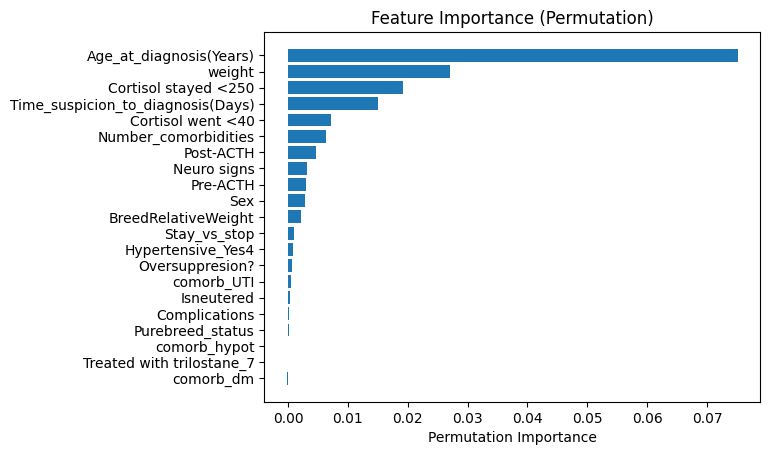

In [41]:
# Calculating the permutation importance
result = permutation_importance(rsf, X, y, n_repeats=10, random_state=55)

# Displaying the feature importance from permutation importance
sorted_idx = result.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation)")
plt.show()

In [42]:
# Calculating the permutation importance
# Feature Importance not available in this package
result = permutation_importance(rsf, X, y, n_repeats=10, random_state=55)

# Creating a DataFrame to display the results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
})

# Sorting by importance
importance_df = importance_df.sort_values(by='Importance Mean', ascending=False)

# Displaying the feature importance
print(importance_df)

                              Feature  Importance Mean  Importance Std
19            Age_at_diagnosis(Years)         0.075152        0.018984
18                             weight         0.027076        0.008896
4                Cortisol stayed <250         0.019158        0.011958
20  Time_suspicion_to_diagnosis(Days)         0.015084        0.004379
5                   Cortisol went <40         0.007233        0.009773
6                Number_comorbidities         0.006354        0.002053
17                          Post-ACTH         0.004651        0.001002
0                         Neuro signs         0.003097        0.002291
16                           Pre-ACTH         0.002974        0.000757
10                                Sex         0.002799        0.000702
12                BreedRelativeWeight         0.002120        0.000745
14                       Stay_vs_stop         0.001065        0.000501
2                   Hypertensive_Yes4         0.000859        0.000336
3     

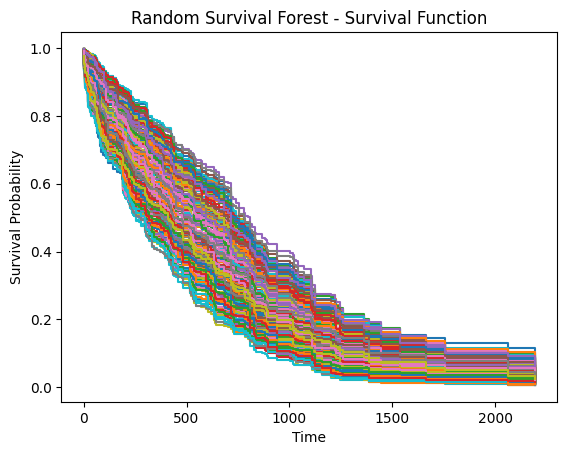

In [43]:
# Predicting the survival function for each individual in X
predicted_survival = rsf.predict_survival_function(X)

# Visualization of survival functions for each individual
for i in range(len(predicted_survival)):
    plt.step(predicted_survival[i].x, predicted_survival[i].y, where="post", label=f'Individual {i+1}')

plt.title("Random Survival Forest - Survival Function")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()